# Load Data

In [319]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# columns correspond to unitigs so we must transpose this table
def load_unitig_data(path) -> pd.DataFrame:
    sr = pd.read_csv(path, sep=' ')
    sr.set_index('pattern_id',inplace=True)
    return sr.T[1:]

azm_sr = load_unitig_data("azm_sr_gwas_filtered_unitigs.Rtab")
cfx_sr = load_unitig_data("cfx_sr_gwas_filtered_unitigs.Rtab")
cip_sr = load_unitig_data("cip_sr_gwas_filtered_unitigs.Rtab")

metadata = pd.read_csv('metadata.csv')
metadata.set_index('Sample_ID',inplace=True)


In [320]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3786 entries, ERR1549286 to ERR2172354
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            3536 non-null   float64
 1   Country         3785 non-null   object 
 2   Continent       3785 non-null   object 
 3   Beta.lactamase  1927 non-null   object 
 4   Azithromycin    3480 non-null   object 
 5   Ciprofloxacin   3129 non-null   object 
 6   Ceftriaxone     3436 non-null   object 
 7   Cefixime        3405 non-null   object 
 8   Tetracycline    1472 non-null   object 
 9   Penicillin      1465 non-null   object 
 10  NG_MAST         3779 non-null   object 
 11  Group           3786 non-null   int64  
 12  azm_mic         3478 non-null   float64
 13  cip_mic         3088 non-null   float64
 14  cro_mic         3434 non-null   float64
 15  cfx_mic         3401 non-null   float64
 16  tet_mic         1472 non-null   float64
 17  pen_mic         1465 no

In [321]:
metadata.head(5)

Year Country Continent Beta.lactamase Azithromycin  \
Sample_ID                                                          
ERR1549286  2015.0      UK    Europe            NaN         >256   
ERR1549290  2015.0      UK    Europe            NaN         >256   
ERR1549291  2015.0      UK    Europe            NaN         >256   
ERR1549287  2015.0      UK    Europe            NaN         >256   
ERR1549288  2015.0      UK    Europe            NaN         >256   

           Ciprofloxacin Ceftriaxone Cefixime Tetracycline Penicillin  ...  \
Sample_ID                                                              ...   
ERR1549286           NaN       0.016      NaN          NaN        NaN  ...   
ERR1549290           NaN       0.004      NaN          NaN        NaN  ...   
ERR1549291           NaN       0.006      NaN          NaN        NaN  ...   
ERR1549287           NaN       0.006      NaN          NaN        NaN  ...   
ERR1549288           NaN       0.008      NaN          NaN        NaN  ...   

           log2_cro_mic  log2_cfx_mic  log2_tet_mic  log2_pen_mic  azm_sr  \
Sample_ID                                                                   
ERR1549286    -5.965784           NaN           NaN           NaN     1.0   
ERR1549290    -7.965784           NaN           NaN           NaN     1.0   
ERR1549291    -7.380822           NaN           NaN           NaN     1.0   
ERR1549287    -7.380822           NaN           NaN           NaN     1.0   
ERR1549288    -6.965784           NaN           NaN           NaN     1.0   

            cip_sr  cro_sr  cfx_sr  tet_sr  pen_sr  
Sample_ID                                           
ERR1549286     NaN     0.0     NaN     NaN     NaN  
ERR1549290     NaN     0.0     NaN     NaN     NaN  
ERR1549291     NaN     0.0     NaN     NaN     NaN  
ERR1549287     NaN     0.0     NaN     NaN     NaN  
ERR1549288     NaN     0.0     NaN     NaN     NaN  

[5 rows x 30 columns]

# Null/NA Cleaning in Labels

1. Remove rows with NaN in the labels we are trying to predict: 'azm_sr','cfx_sr', 'cip_sr'.
---

Note to Jacob:
If I remove all rows with nulls, then we drop down to ~1k entries. Not ideal. I will remove only the nulls in the target labels. By doing that I was able to preserve ~2800 entries.

Additionally, I can technically replace the nulls in the feature set with averages whether they are continuous or discrete, but since we are going to be building some kind of predictive model later, it would be bad practice to run column averages in df.fillna() before we split our dataset into training and test sets.

Therefore, I am going to split the dataset into a training and test set first.

What do you think?

-Jacob
We could evaluate how to fill the NaN values based on how the data is skewed for each feature we want to predict. 
if skew > 0 -> fill NaN with mean .. there are more 0s than 1s, mean will reflect the distribution of 0s and 1s
else if skew < 0 -> fill NaN with median .. there are more 1s than 0s, using the median ensures our negatively skewed data wont be affected by an uneven distribution of 0s and 1s when we fill it


In [322]:

def impute_cols_by_skew(df, columns):
    for column_name in columns:
        sr_skew = df[column_name].skew()
        impute_value = None
        if sr_skew > 0:
            impute_value = df[column_name].mean()
        elif sr_skew < 0:
            impute_value = df[column_name].median()
        df[column_name].fillna(impute_value, inplace=True)

#metadata.dropna(axis=0, how='any', inplace=True, subset=['azm_sr', 'cfx_sr', 'cip_sr'])

It looks like they're all positively skewed so we can use mean values, lets try continuous for now and see what happens. It was worth trying this though

In [323]:
metadata.head(5)

Year Country Continent Beta.lactamase Azithromycin  \
Sample_ID                                                          
ERR1549286  2015.0      UK    Europe            NaN         >256   
ERR1549290  2015.0      UK    Europe            NaN         >256   
ERR1549291  2015.0      UK    Europe            NaN         >256   
ERR1549287  2015.0      UK    Europe            NaN         >256   
ERR1549288  2015.0      UK    Europe            NaN         >256   

           Ciprofloxacin Ceftriaxone Cefixime Tetracycline Penicillin  ...  \
Sample_ID                                                              ...   
ERR1549286           NaN       0.016      NaN          NaN        NaN  ...   
ERR1549290           NaN       0.004      NaN          NaN        NaN  ...   
ERR1549291           NaN       0.006      NaN          NaN        NaN  ...   
ERR1549287           NaN       0.006      NaN          NaN        NaN  ...   
ERR1549288           NaN       0.008      NaN          NaN        NaN  ...   

           log2_cro_mic  log2_cfx_mic  log2_tet_mic  log2_pen_mic  azm_sr  \
Sample_ID                                                                   
ERR1549286    -5.965784           NaN           NaN           NaN     1.0   
ERR1549290    -7.965784           NaN           NaN           NaN     1.0   
ERR1549291    -7.380822           NaN           NaN           NaN     1.0   
ERR1549287    -7.380822           NaN           NaN           NaN     1.0   
ERR1549288    -6.965784           NaN           NaN           NaN     1.0   

            cip_sr  cro_sr  cfx_sr  tet_sr  pen_sr  
Sample_ID                                           
ERR1549286     NaN     0.0     NaN     NaN     NaN  
ERR1549290     NaN     0.0     NaN     NaN     NaN  
ERR1549291     NaN     0.0     NaN     NaN     NaN  
ERR1549287     NaN     0.0     NaN     NaN     NaN  
ERR1549288     NaN     0.0     NaN     NaN     NaN  

[5 rows x 30 columns]

# Removing Un-used labels (Ground truth)
2. Removing 'Year', and unimportant labels 'cro_sr', 'tet_sr', 'pen_sr'. We are not using these labels and keeping them will only introduce unecessary complexity to our model.

In [324]:
useless_columns = ['Year', 'cro_sr', 'tet_sr', 'pen_sr']

metadata.drop(labels=useless_columns, axis=1, inplace=True)

In [325]:
metadata.columns

Index(['Country', 'Continent', 'Beta.lactamase', 'Azithromycin',
       'Ciprofloxacin', 'Ceftriaxone', 'Cefixime', 'Tetracycline',
       'Penicillin', 'NG_MAST', 'Group', 'azm_mic', 'cip_mic', 'cro_mic',
       'cfx_mic', 'tet_mic', 'pen_mic', 'log2_azm_mic', 'log2_cip_mic',
       'log2_cro_mic', 'log2_cfx_mic', 'log2_tet_mic', 'log2_pen_mic',
       'azm_sr', 'cip_sr', 'cfx_sr'],
      dtype='object')

# Remove Duplicates

3. Removing Duplicate entries in the dataframe. Duplicates will lead to a misrepresentation of the actual data and a flawed model so its important that we remove them.

In [326]:
metadata.drop_duplicates(inplace=True)

## Remove Symbols
4. Removing symbols and non-usable characters from all fields. This allows us to easily encode the entries into numeric or binary features that we can actually use

In [327]:
def remove_symbols_from_column(col):
    if col.dtype == object:  #check if strong
        return col.str.replace(r'[^a-zA-Z0-9]', '', regex=True)
    else:  #do nothing
        return col

metadata = metadata.apply(remove_symbols_from_column)

# Cleaning non-numeric entries in numeric fields to NaN.

5. Turn Non Numeric Entries in Numeric Columns into NaN
6. Cast all numeric rows into float32
---


Notes: Turning them into NaN for now. Will engineer values for all NaNs after train and test splits are made

In [328]:
numeric_columns = [
'Azithromycin',
'Ciprofloxacin',
'Ceftriaxone',
'Cefixime',
'Tetracycline',
'Penicillin',
'NG_MAST',
'Group',
'azm_mic',
'cip_mic',
'cro_mic',
'cfx_mic',
'tet_mic',
'pen_mic',
'log2_azm_mic',
'log2_cip_mic',
'log2_cro_mic',
'log2_cfx_mic',
'log2_tet_mic',
'log2_pen_mic',
'azm_sr',
'cfx_sr',
'cip_sr'
]

for column in numeric_columns:
    metadata[column] = pd.to_numeric(metadata[column], errors='coerce', downcast="float") #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html

In [329]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3113 entries, ERR1549286 to ERR2172346
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         3112 non-null   object 
 1   Continent       3112 non-null   object 
 2   Beta.lactamase  1561 non-null   object 
 3   Azithromycin    2865 non-null   float32
 4   Ciprofloxacin   2626 non-null   float32
 5   Ceftriaxone     2858 non-null   float32
 6   Cefixime        2843 non-null   float32
 7   Tetracycline    1284 non-null   float32
 8   Penicillin      1278 non-null   float32
 9   NG_MAST         2671 non-null   float32
 10  Group           3113 non-null   float32
 11  azm_mic         2863 non-null   float32
 12  cip_mic         2626 non-null   float32
 13  cro_mic         2858 non-null   float32
 14  cfx_mic         2841 non-null   float32
 15  tet_mic         1284 non-null   float32
 16  pen_mic         1278 non-null   float32
 17  log2_azm_mic    2863 no

In [330]:
metadata.head(10)

Country Continent Beta.lactamase  Azithromycin  Ciprofloxacin  \
Sample_ID                                                                  
ERR1549286      UK    Europe            NaN         256.0            NaN   
ERR1549290      UK    Europe            NaN         256.0            NaN   
ERR1549291      UK    Europe            NaN         256.0            NaN   
ERR1549288      UK    Europe            NaN         256.0            NaN   
ERR1549299      UK    Europe            NaN         256.0            NaN   
ERR1549292      UK    Europe            NaN         256.0            NaN   
ERR1549298      UK    Europe            NaN           5.0            NaN   
ERR1549300      UK    Europe            NaN         256.0            NaN   
ERR1549295      UK    Europe            NaN          75.0            NaN   
ERR1549294      UK    Europe            NaN          75.0            NaN   

            Ceftriaxone  Cefixime  Tetracycline  Penicillin  NG_MAST  ...  \
Sample_ID                                                             ...   
ERR1549286         16.0       NaN           NaN         NaN   9768.0  ...   
ERR1549290          4.0       NaN           NaN         NaN   9768.0  ...   
ERR1549291          6.0       NaN           NaN         NaN   9768.0  ...   
ERR1549288          8.0       NaN           NaN         NaN   9768.0  ...   
ERR1549299         12.0       NaN           NaN         NaN      NaN  ...   
ERR1549292         23.0       NaN           NaN         NaN   9768.0  ...   
ERR1549298         94.0       NaN           NaN         NaN      NaN  ...   
ERR1549300          8.0       NaN           NaN         NaN      NaN  ...   
ERR1549295         94.0       NaN           NaN         NaN      NaN  ...   
ERR1549294         94.0       NaN           NaN         NaN   1407.0  ...   

            pen_mic  log2_azm_mic  log2_cip_mic  log2_cro_mic  log2_cfx_mic  \
Sample_ID                                                                     
ERR1549286      NaN      9.000000           NaN     -5.965784           NaN   
ERR1549290      NaN      9.000000           NaN     -7.965784           NaN   
ERR1549291      NaN      9.000000           NaN     -7.380822           NaN   
ERR1549288      NaN      9.000000           NaN     -6.965784           NaN   
ERR1549299      NaN      9.000000           NaN     -6.380822           NaN   
ERR1549292      NaN      9.000000           NaN     -5.442222           NaN   
ERR1549298      NaN     -1.000000           NaN     -3.411196           NaN   
ERR1549300      NaN      9.000000           NaN     -6.965784           NaN   
ERR1549295      NaN     -0.415038           NaN     -3.411196           NaN   
ERR1549294      NaN     -0.415038           NaN     -3.411196           NaN   

            log2_tet_mic  log2_pen_mic  azm_sr  cip_sr  cfx_sr  
Sample_ID                                                       
ERR1549286           NaN           NaN     1.0     NaN     NaN  
ERR1549290           NaN           NaN     1.0     NaN     NaN  
ERR1549291           NaN           NaN     1.0     NaN     NaN  
ERR1549288           NaN           NaN     1.0     NaN     NaN  
ERR1549299           NaN           NaN     1.0     NaN     NaN  
ERR1549292           NaN           NaN     1.0     NaN     NaN  
ERR1549298           NaN           NaN     0.0     NaN     NaN  
ERR1549300           NaN           NaN     1.0     NaN     NaN  
ERR1549295           NaN           NaN     0.0     NaN     NaN  
ERR1549294           NaN           NaN     0.0     NaN     NaN  

[10 rows x 26 columns]

# One Hot Encode Categorical Columns

7. Turn Categorical Location entries into numerical representation https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
8. Handle 'Beta.lactamase' special case, as it is discrete with many NaNs. Cannot be engineered in the same way as continuous features. One hot encode like the other discrete features but set to all 0 if NaN

In [331]:
geographic_columns=['Country', 'Continent']
#metadata = pd.get_dummies(data=metadata, prefix="Encoded", columns=geographic_columns, dtype=float)
#metadata = pd.get_dummies(data=metadata, prefix="Encoded_Beta.lactamase", columns=['Beta.lactamase'], dtype=float)


In [332]:
metadata.head(5)

Country Continent Beta.lactamase  Azithromycin  Ciprofloxacin  \
Sample_ID                                                                  
ERR1549286      UK    Europe            NaN         256.0            NaN   
ERR1549290      UK    Europe            NaN         256.0            NaN   
ERR1549291      UK    Europe            NaN         256.0            NaN   
ERR1549288      UK    Europe            NaN         256.0            NaN   
ERR1549299      UK    Europe            NaN         256.0            NaN   

            Ceftriaxone  Cefixime  Tetracycline  Penicillin  NG_MAST  ...  \
Sample_ID                                                             ...   
ERR1549286         16.0       NaN           NaN         NaN   9768.0  ...   
ERR1549290          4.0       NaN           NaN         NaN   9768.0  ...   
ERR1549291          6.0       NaN           NaN         NaN   9768.0  ...   
ERR1549288          8.0       NaN           NaN         NaN   9768.0  ...   
ERR1549299         12.0       NaN           NaN         NaN      NaN  ...   

            pen_mic  log2_azm_mic  log2_cip_mic  log2_cro_mic  log2_cfx_mic  \
Sample_ID                                                                     
ERR1549286      NaN           9.0           NaN     -5.965784           NaN   
ERR1549290      NaN           9.0           NaN     -7.965784           NaN   
ERR1549291      NaN           9.0           NaN     -7.380822           NaN   
ERR1549288      NaN           9.0           NaN     -6.965784           NaN   
ERR1549299      NaN           9.0           NaN     -6.380822           NaN   

            log2_tet_mic  log2_pen_mic  azm_sr  cip_sr  cfx_sr  
Sample_ID                                                       
ERR1549286           NaN           NaN     1.0     NaN     NaN  
ERR1549290           NaN           NaN     1.0     NaN     NaN  
ERR1549291           NaN           NaN     1.0     NaN     NaN  
ERR1549288           NaN           NaN     1.0     NaN     NaN  
ERR1549299           NaN           NaN     1.0     NaN     NaN  

[5 rows x 26 columns]

In [333]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3113 entries, ERR1549286 to ERR2172346
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         3112 non-null   object 
 1   Continent       3112 non-null   object 
 2   Beta.lactamase  1561 non-null   object 
 3   Azithromycin    2865 non-null   float32
 4   Ciprofloxacin   2626 non-null   float32
 5   Ceftriaxone     2858 non-null   float32
 6   Cefixime        2843 non-null   float32
 7   Tetracycline    1284 non-null   float32
 8   Penicillin      1278 non-null   float32
 9   NG_MAST         2671 non-null   float32
 10  Group           3113 non-null   float32
 11  azm_mic         2863 non-null   float32
 12  cip_mic         2626 non-null   float32
 13  cro_mic         2858 non-null   float32
 14  cfx_mic         2841 non-null   float32
 15  tet_mic         1284 non-null   float32
 16  pen_mic         1278 non-null   float32
 17  log2_azm_mic    2863 no

# Split Dataframe into Train and Test

9. To ensure that we can do normalization later as it is good practice to split before normalization
We need to partition our data so that our model will be able to learn off the training data and measure its performance on a completely independent set. It lets us know if the model is able to find any relationship or if its overfitting data

In [334]:
from sklearn.model_selection import train_test_split
train_inputs,test_inputs = train_test_split(metadata, test_size=0.20, random_state=42)   # partition and mix entries
print(train_inputs.shape,":", test_inputs.shape)

(2490, 26) : (623, 26)


# Engineer/Impute Values for NaN numerical values

10. Fill out gaps with skew imputation in numeric columns so we have more data by avoiding dropping all rows with NaN. More entries is better and as long as our imputed values accurately represent the rest of the data then it shouldn't be detrimental to our model

In [335]:
# apply skew based imputation

targets = numeric_columns
impute_cols_by_skew(train_inputs, targets)
impute_cols_by_skew(test_inputs, targets)




In [336]:
train_inputs.head(5)

Country Continent Beta.lactamase  Azithromycin  Ciprofloxacin  \
Sample_ID                                                                    
16933_2#60  Slovakia    Europe            NaN    143.645309       3.000000   
16933_2#61   Hungary    Europe            NaN    143.645309      12.711384   
10625_6#93     Japan      Asia              S     25.000000      32.000000   
8727_5#76        USA   America              S     16.000000      15.000000   
17428_6#28  Portugal    Europe            NaN     47.000000       3.000000   

            Ceftriaxone  Cefixime  Tetracycline  Penicillin       NG_MAST  \
Sample_ID                                                                   
16933_2#60          8.0      16.0     15.560118   19.373648  10800.000000   
16933_2#61         12.0      16.0     15.560118   19.373648  11045.000000   
10625_6#93        125.0      38.0      3.000000    4.000000   2958.000000   
8727_5#76           8.0      15.0      5.000000   25.000000   4123.210938   
17428_6#28          3.0      16.0     15.560118   19.373648   4330.000000   

            ...   pen_mic  log2_azm_mic  log2_cip_mic  log2_cro_mic  \
Sample_ID   ...                                                       
16933_2#60  ...  2.851375     -1.410605     -8.380822     -6.965784   
16933_2#61  ...  2.851375     -1.410605     -2.106307     -6.380822   
10625_6#93  ...  4.000000     -2.000000      5.000000     -3.000000   
8727_5#76   ...  0.250000      4.000000     -6.058894     -6.965784   
17428_6#28  ...  2.851375     -4.411195     -8.380822     -8.380822   

            log2_cfx_mic  log2_tet_mic  log2_pen_mic    azm_sr    cip_sr  \
Sample_ID                                                                  
16933_2#60     -5.965784      0.916162     -0.415038  0.107672  0.000000   
16933_2#61     -5.965784      0.916162     -0.415038  0.107672  0.453472   
10625_6#93     -1.395929      1.584962      2.000000  0.000000  1.000000   
8727_5#76      -6.058894     -1.000000     -2.000000  1.000000  0.000000   
17428_6#28     -5.965784      0.916162     -0.415038  0.000000  0.000000   

            cfx_sr  
Sample_ID           
16933_2#60     0.0  
16933_2#61     0.0  
10625_6#93     0.0  
8727_5#76      0.0  
17428_6#28     0.0  

[5 rows x 26 columns]

# Normalize Numerical Features 

11. Scale all numerical columns' values to be between 0 and 1, this will preserve consistency in the distribution while being easier for the model to interpret. Normalization also prevents numerical instability when training the model

In [337]:
#from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler()

train_inputs[numeric_columns] = normalizer.fit_transform(train_inputs[numeric_columns])
test_inputs[numeric_columns] = normalizer.fit_transform(test_inputs[numeric_columns])

train_inputs.head(5)

Country Continent Beta.lactamase  Azithromycin  Ciprofloxacin  \
Sample_ID                                                                    
16933_2#60  Slovakia    Europe            NaN      0.000556       0.011905   
16933_2#61   Hungary    Europe            NaN      0.000556       0.069711   
10625_6#93     Japan      Asia              S      0.000094       0.184524   
8727_5#76        USA   America              S      0.000058       0.083333   
17428_6#28  Portugal    Europe            NaN      0.000179       0.011905   

             Ceftriaxone  Cefixime  Tetracycline  Penicillin   NG_MAST  ...  \
Sample_ID                                                               ...   
16933_2#60  1.000000e-06  0.120968      0.057099    0.144674  0.731126  ...   
16933_2#61  1.571429e-06  0.120968      0.057099    0.144674  0.747715  ...   
10625_6#93  1.771429e-05  0.298387      0.007843    0.023622  0.200149  ...   
8727_5#76   1.000000e-06  0.112903      0.015686    0.188976  0.279045  ...   
17428_6#28  2.857143e-07  0.120968      0.057099    0.144674  0.293046  ...   

             pen_mic  log2_azm_mic  log2_cip_mic  log2_cro_mic  log2_cfx_mic  \
Sample_ID                                                                      
16933_2#60  0.022261      0.289453      0.099272      0.385630      0.308504   
16933_2#61  0.022261      0.289453      0.492270      0.430746      0.308504   
10625_6#93  0.031235      0.252751      0.937366      0.691496      0.660959   
8727_5#76   0.001938      0.626375      0.244704      0.385630      0.301323   
17428_6#28  0.022261      0.102603      0.099272      0.276494      0.308504   

            log2_tet_mic  log2_pen_mic    azm_sr    cip_sr  cfx_sr  
Sample_ID                                                           
16933_2#60      0.526664      0.535567  0.107672  0.000000     0.0  
16933_2#61      0.526664      0.535567  0.107672  0.453472     0.0  
10625_6#93      0.571353      0.686830  0.000000  1.000000     0.0  
8727_5#76       0.398628      0.436294  1.000000  0.000000     0.0  
17428_6#28      0.526664      0.535567  0.000000  0.000000     0.0  

[5 rows x 26 columns]

# EDA STEPS

### Data Stats

1. Showing percentage of rows that are in the 3 different label categories

In [338]:
j=[0,0,0]
samples = train_inputs.index
for sample in samples:
    if metadata['azm_sr'][sample]:
        j[0] +=1
    if metadata['cfx_sr'][sample]:
        j[1] +=1
    if metadata['cip_sr'][sample]:
        j[2] +=1

print(j[0]/len(samples), "% of samples have resistance to azm")
print(j[1]/len(samples), "% of samples have resistance to cfx")
print(j[2]/len(samples), "% of samples have resistance to cip")


0.17791164658634537 % of samples have resistance to azm
0.09116465863453815 % of samples have resistance to cfx
0.5353413654618474 % of samples have resistance to cip


## Calculate mean, median, mode, variance, and standard deviation

2. Get basic stats on the different columns. This gives us an idea of the typical distribution and average value in each column

In [339]:
for column in numeric_columns:
    print("=================  Column : " + str(column) + "  =================")
    print(f"Mean :  {train_inputs[column].mean()}")
    print(f"Median : {train_inputs[column].median()}")
    print(f"Mode : {train_inputs[column].mode()}")
    print(f"Std : {train_inputs[column].std()}")
    print(f"Variance : {train_inputs[column].var()}")

=================  Column : Azithromycin  =================
Mean :  0.0005560982972383499
Median : 7.017242751317099e-05
Mode : 0    0.000094
Name: Azithromycin, dtype: float32
Std : 0.020038124173879623
Variance : 0.0004015264566987753
=================  Column : Ciprofloxacin  =================
Mean :  0.0697106271982193
Median : 0.0697106197476387
Mode : 0    0.017857
Name: Ciprofloxacin, dtype: float32
Std : 0.08158428966999054
Variance : 0.006655996665358543
=================  Column : Ceftriaxone  =================
Mean :  0.0010657630627974868
Median : 1.0000001111620804e-06
Mode : 0    0.000001
Name: Ceftriaxone, dtype: float32
Std : 0.02960214950144291
Variance : 0.000876287289429456
=================  Column : Cefixime  =================
Mean :  0.18553008139133453
Median : 0.12096773833036423
Mode : 0    0.120968
Name: Cefixime, dtype: float32
Std : 0.22670280933380127
Variance : 0.05139416083693504
=================  Column : Tetracycline  =================
Mean :  0.057098

## Univariate Analysis (Distr. of individual variables)

3.
* plot shape of feature distributions, this is to visualize skew and whatnot. 
* Potentially apply some pure function to re-engineer the distribution to look more like a normal distribution if needed

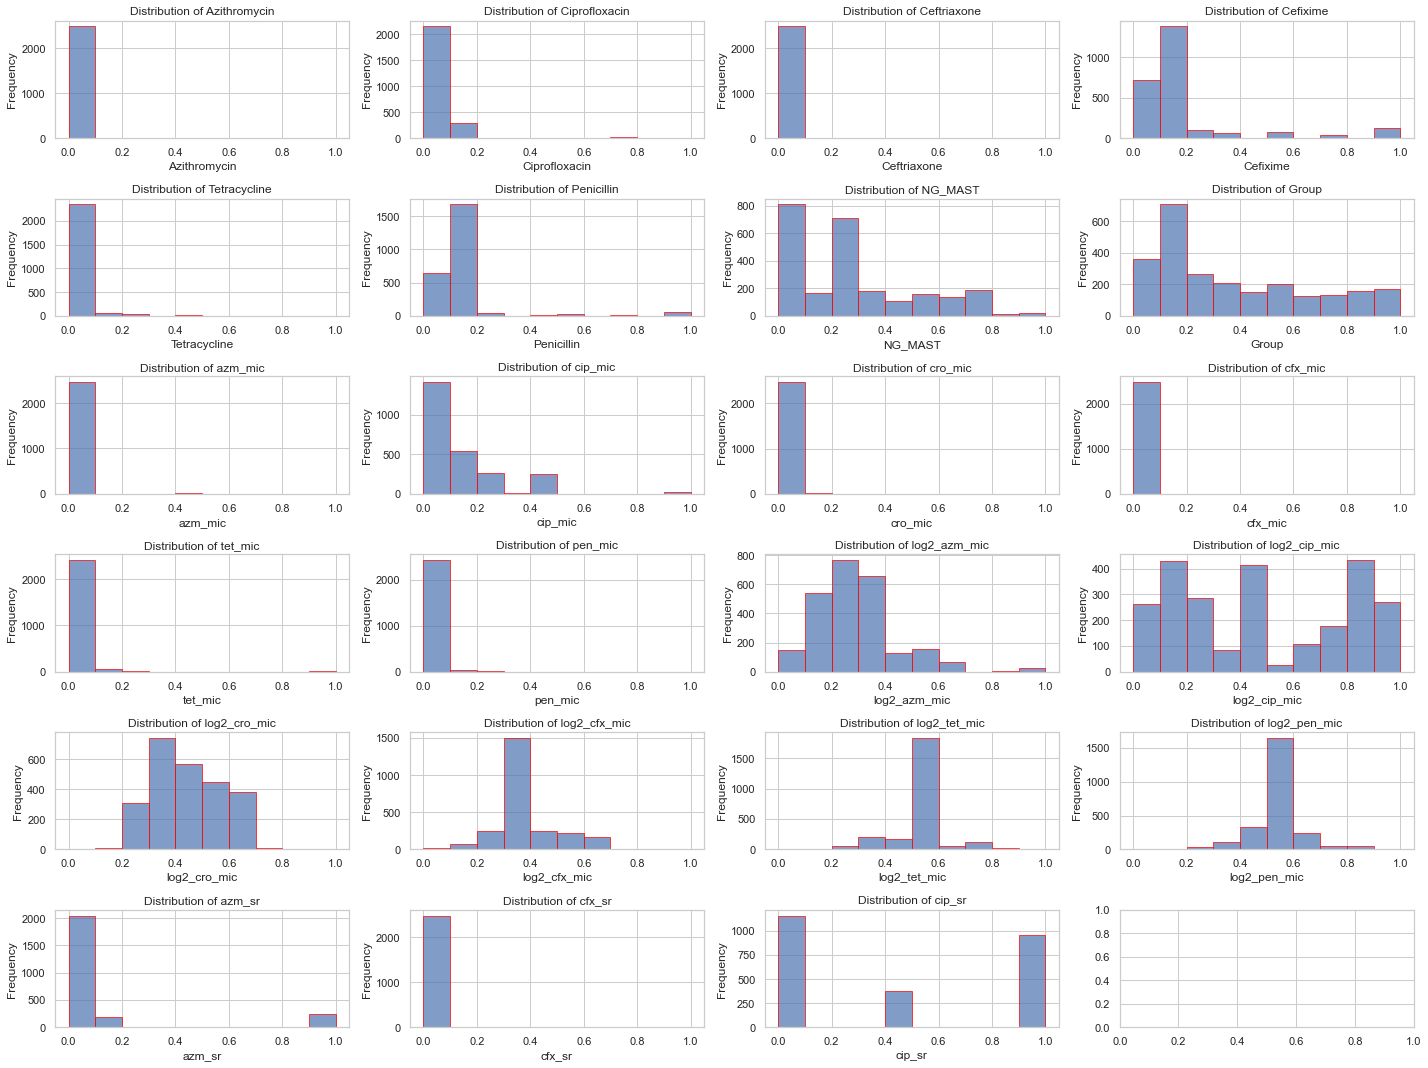

In [340]:
fig, axes = plt.subplots(6, 4, figsize=(20, 15))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    axes[i].hist(train_inputs[column], bins=10, edgecolor='red', alpha=0.7)
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## Multivariate Analysis (Show relationship of individual variables wrt to labels, pair plots and such) 



### Show impact of numerical features on the 3 different labels

4. Visualize numerical features plotted against the different labels. This provides insights into how variations in numerical features impact the labels

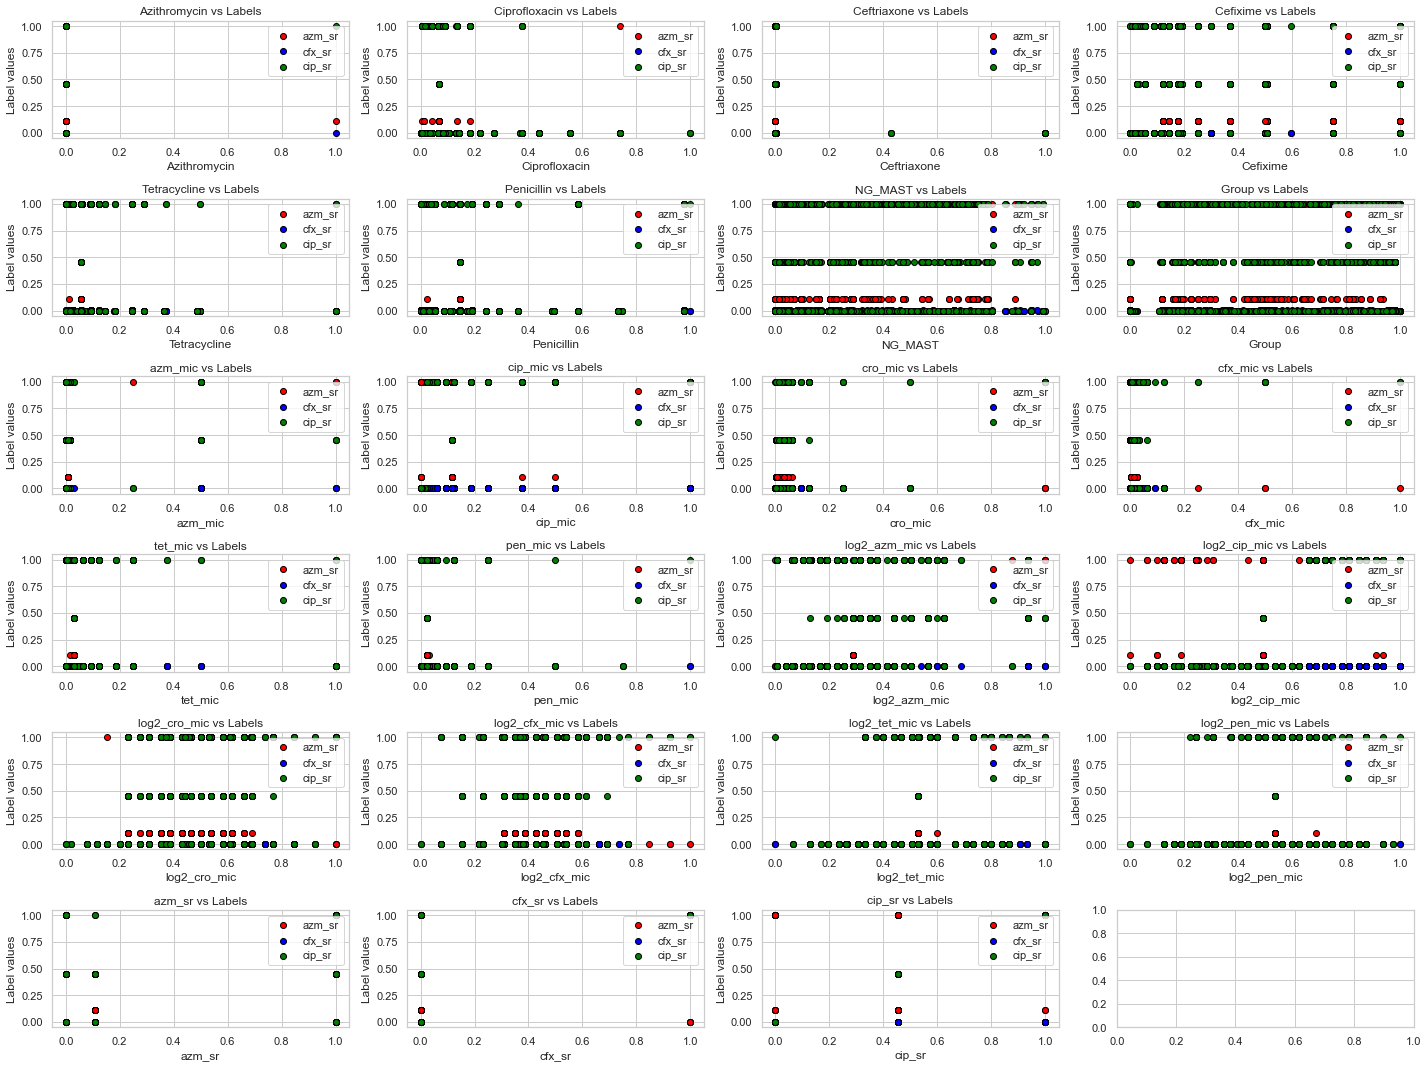

In [341]:
fig, axes = plt.subplots(6, 4, figsize=(20, 15))


axes = axes.flatten()

for i, column in enumerate(numeric_columns):

    axes[i].scatter(train_inputs[column], train_inputs["azm_sr"], label='azm_sr', color='red', edgecolor='black')
    
    axes[i].scatter(train_inputs[column], train_inputs["cfx_sr"], label='cfx_sr', color='blue', edgecolor='black')

    axes[i].scatter(train_inputs[column], train_inputs["cip_sr"], label='cip_sr', color='green', edgecolor='black')

    axes[i].set_title(f'{column} vs Labels')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Label values')
    axes[i].grid(True) #Qol

    axes[i].legend()


plt.tight_layout()
plt.show()

## Correlation Analysis (Pearson, Spearman, etc)


5. Calculate and visualize each feature's impact on the label. By quantifying the strength and direction of the relationships between features and labels, we can effectively display these correlations. This helps identify what features are the most influencial

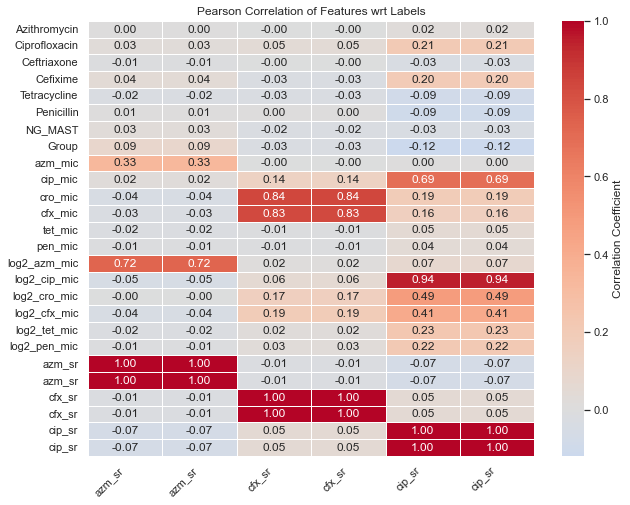

In [342]:
label_columns = ['azm_sr', 'cfx_sr', 'cip_sr'] #Separated labels from numerical columns
stacked = numeric_columns + label_columns 
stackedDF = train_inputs[stacked].astype(float) 


correlation_matrix = stackedDF.corr() #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html   !!! Pearson by default
feature_label_corr = correlation_matrix.loc[numeric_columns, label_columns] #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html


plt.figure(figsize=(10, 8)) #Need to use seaborn. idk how to make matplotlib heatmap
sns.heatmap(
    feature_label_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    fmt=".2f",
    cbar_kws={'label': 'Correlation Coefficient'} 
)
plt.title("Pearson Correlation of Features wrt Labels")
plt.xticks(rotation=45, ha='right') #Qol

plt.show()




# Extract important features
6. Look at correlation visualization and record most impactful features and separate them by label. Threshold > +0.05. This step helps in selecting the most relevant features so that we dont include a lot of features in our model that will be useless in regard to our analysis.

In [343]:
impact_threshold = 0.05


feature_impact = {}

for label in label_columns:
    correlations = feature_label_corr[label]

    significant_features = correlations[abs(correlations) > impact_threshold].index.tolist() #abs because negative impacts matter too
    feature_impact[label] = significant_features


for label, features in feature_impact.items():
    print(f"Impactful features for {label}")
    for feature in features:
        corr_value = feature_label_corr.loc[feature, label]
        print(f" * {feature}: Correlation = {corr_value}")

#print(feature_impact)

#feature_impact will be dictionary of all impactful features for every label (key)

Impactful features for azm_sr
 * Azithromycin: Correlation = azm_sr    0.000411
azm_sr    0.000411
Name: Azithromycin, dtype: float64
 * Ciprofloxacin: Correlation = azm_sr    0.028702
azm_sr    0.028702
Name: Ciprofloxacin, dtype: float64
 * Ceftriaxone: Correlation = azm_sr   -0.01213
azm_sr   -0.01213
Name: Ceftriaxone, dtype: float64
 * Cefixime: Correlation = azm_sr    0.044791
azm_sr    0.044791
Name: Cefixime, dtype: float64
 * Tetracycline: Correlation = azm_sr   -0.023482
azm_sr   -0.023482
Name: Tetracycline, dtype: float64
 * Penicillin: Correlation = azm_sr    0.005694
azm_sr    0.005694
Name: Penicillin, dtype: float64
 * NG_MAST: Correlation = azm_sr    0.02613
azm_sr    0.02613
Name: NG_MAST, dtype: float64
 * Group: Correlation = azm_sr    0.093145
azm_sr    0.093145
Name: Group, dtype: float64
 * azm_mic: Correlation = azm_sr    0.333099
azm_sr    0.333099
Name: azm_mic, dtype: float64
 * cip_mic: Correlation = azm_sr    0.023752
azm_sr    0.023752
Name: cip_mic, dtype

## Outlier Detection (box plots, then remove outliers)

7. Replace outliers with average of that column. Ensure it is numerical column. Outliers may give our model a biased perspective on the majority of the data and leads to less accurate predictions. Replacing the outliers maintains the integrity of the dataset while minimizing the impact of extreme values.

training data


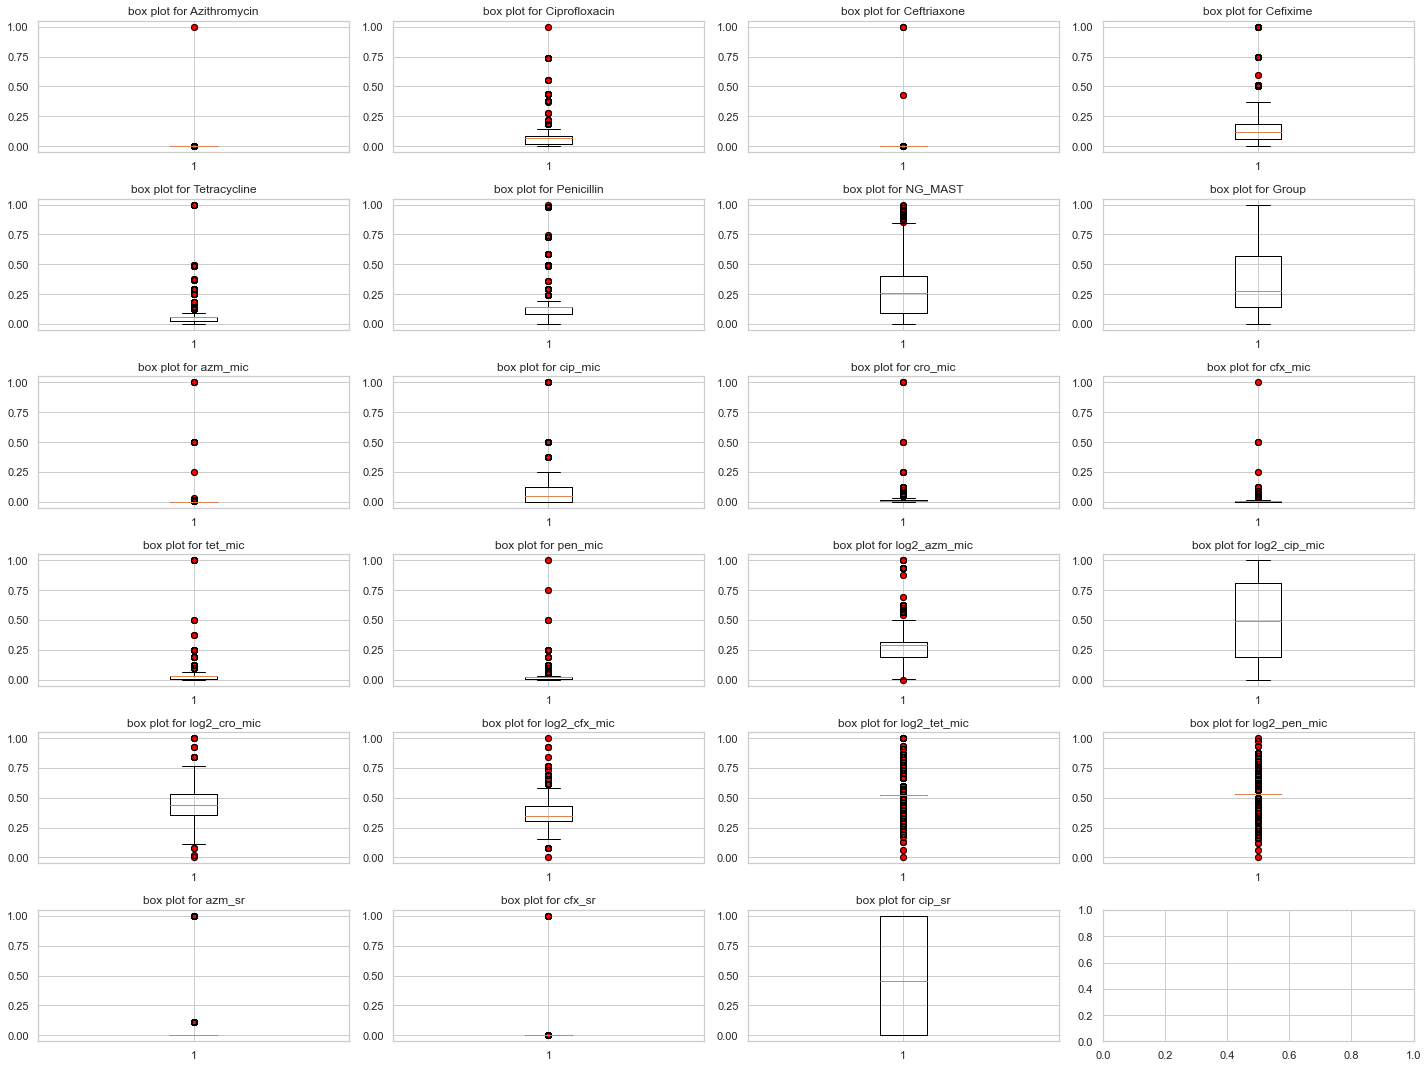

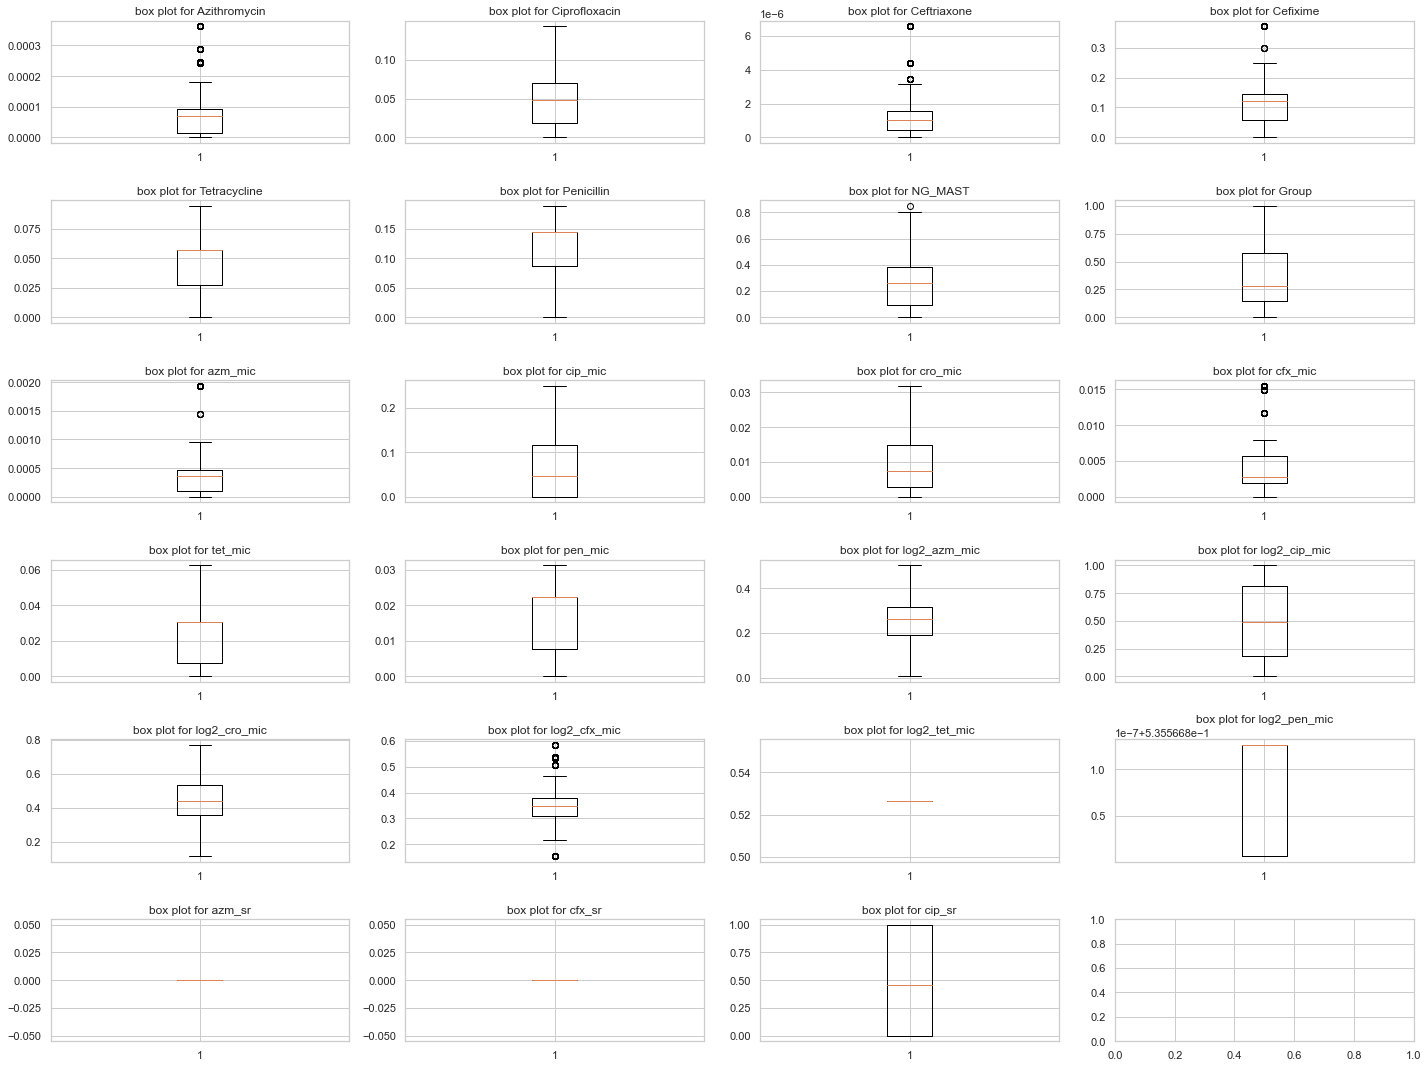

In [344]:

def outlier_detection(dataset):

    fig, axes = plt.subplots(6, 4, figsize=(20, 15))

    axes = axes.flatten()
    # before
    for i, col in enumerate(numeric_columns):
        Q1 = dataset[col].quantile(0.25)
        Q3 = dataset[col].quantile(0.75)
        IQR = Q3-Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = dataset[col][(dataset[col] < lower_bound) | (dataset[col] > upper_bound)]
        non_outliers = dataset[col][(dataset[col] >= lower_bound) & (dataset[col] <= upper_bound)]
        mean = non_outliers.mean()        
        
        outliers.size, dataset[col].size
        axes[i].boxplot(dataset[col])
        axes[i].scatter([1]*len(outliers), outliers, color='red')
        axes[i].set_title("box plot for "+ col)
        dataset[col] = dataset[col].apply(lambda x: mean if (x < lower_bound or x > upper_bound) else x)
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(6, 4, figsize=(20, 15))

    # after
    axes = axes.flatten()
    for i, col in enumerate(numeric_columns):
        axes[i].boxplot(dataset[col])
        axes[i].set_title("box plot for "+ col)    
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

print("training data")
outlier_detection(train_inputs)
#print("testing data")
#outlier_detection(test_inputs)


## Pairwise Correlation Between Numeric Features

visualize the parwise relationship between each numeric feature to help us identify potential features we can engineer and expose high impact features

In [345]:
#print(numeric_columns)
#sns.pairplot(train_inputs[numeric_columns])

## Engineering Unitig Features

8. Eliminate non intersecting entries between datasets. Each sample will have a total presence for each of the 3 strains we are looking at. The unitig files have binary entries representing whether or not a unitig was present in the sample. Take the sum of each row to get presence of unitigs for each strain for each sample. This simplifies the unitig data files and may help our statistical model identify the relationship between unitigs and a strains resistance to antibiotics.

In [346]:
import numpy as np

# extract intersection of features from the unitig files

def unitig_metadata_intersect(unitig_data, meta_data):
    # we have to remove the entries from the unitig files not in the metadata file
    meta_data_indicies = meta_data.index.to_list()
    unitig_indicies = unitig_data.index.to_list()
    unitig_intersecting_indicies = np.array([])
    for x in unitig_indicies:
        if x in meta_data_indicies:
            unitig_intersecting_indicies = np.append(unitig_intersecting_indicies, x)

    return unitig_intersecting_indicies

azm_intersecting_indicies = unitig_metadata_intersect(azm_sr, train_inputs)
cip_intersecting_indicies = unitig_metadata_intersect(cip_sr, train_inputs)
cfx_intersecting_indicies = unitig_metadata_intersect(cfx_sr, train_inputs)

azm_sr = azm_sr.loc[azm_intersecting_indicies]
cip_sr = cip_sr.loc[cip_intersecting_indicies]
cfx_sr = cfx_sr.loc[cfx_intersecting_indicies]

print(azm_sr.shape, cip_sr.shape, cfx_sr.shape)

(2490, 515) (2490, 8873) (2490, 384)


## Unitig Presence Visualization
9. Visualize distribution of unitig presence, This step helps us get a good perspective on how the unitig presence varies accross the sample dataset and its distribution. It can help us identify skewness and observe prevalence of different unitigs within the samples providing a clearer picture of the data's characteristics

<Axes: title={'center': 'cfx unitig presence across samples'}, xlabel='pattern_id'>

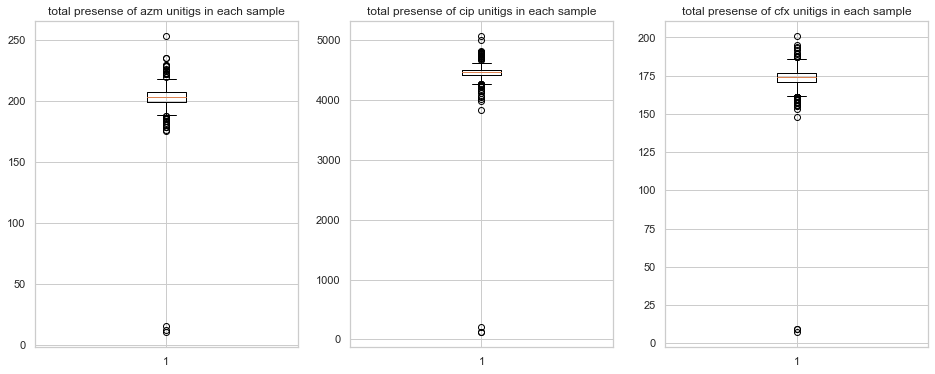

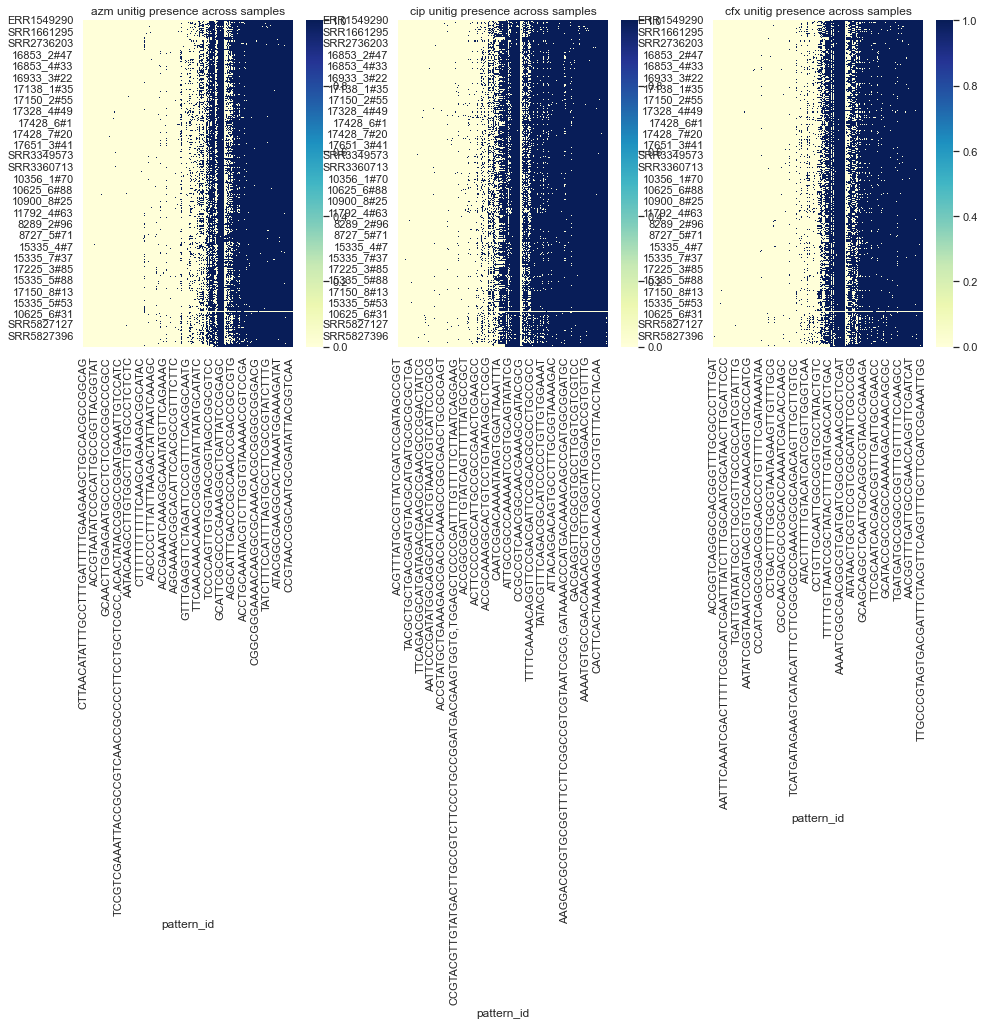

In [347]:
# total presence of unitigs for azm, cfx, cip for each sample
fig, axes = plt.subplots(1,3, figsize=(16,6))
azm_total_presence = azm_sr.sum(axis=1)
axes[0].set_title("total presense of azm unitigs in each sample")
axes[0].boxplot(azm_total_presence)
axes[0].grid(True)

cip_total_presence = cip_sr.sum(axis=1)
axes[1].set_title("total presense of cip unitigs in each sample")
axes[1].boxplot(cip_total_presence)
axes[1].grid(True)

cfx_total_presence = cfx_sr.sum(axis=1)
axes[2].set_title("total presense of cfx unitigs in each sample")
axes[2].boxplot(cfx_total_presence)
axes[2].grid(True)



fig, axes = plt.subplots(1,3, figsize=(16,6))
axes[0].set_title("azm unitig presence across samples")
axes[0].set_ylabel("samples")
axes[0].set_xlabel("unitig presense")
sns.heatmap(azm_sr.iloc[:,:-2], cmap="YlGnBu", ax=axes[0])

axes[1].set_title("cip unitig presence across samples")
axes[1].set_ylabel("samples")
axes[1].set_xlabel("unitig presense")
sns.heatmap(cip_sr.iloc[:,:-2], cmap="YlGnBu", ax=axes[1])

axes[2].set_title("cfx unitig presence across samples")
axes[2].set_ylabel("samples")
axes[2].set_xlabel("unitig presense")
sns.heatmap(cfx_sr.iloc[:,:-2], cmap="YlGnBu", ax=axes[2])


## Mean, Median, Mode, Std, Variance of Unitig Presence
10. evaluate mean, media, mode, std, variance for unitig data. This step provides us with a idea of the typical value and distribution for the unitig presence data

In [348]:
sns.set(style="whitegrid")
azm_presence_mean = azm_total_presence.mean()
cip_presence_mean = cip_total_presence.mean()
cfx_presence_mean = cfx_total_presence.mean()

azm_presence_std = azm_total_presence.std()
cip_presence_std = cip_total_presence.std()
cfx_presence_std = cfx_total_presence.std()

names = ['azm presence', 'cip presence', 'cfx presence']

for i,column in enumerate([azm_total_presence, cip_total_presence, cip_total_presence]):
    print("=================  Column : " + names[i] + "  =================")
    print(f"Mean :  {column.mean()}")
    print(f"Median : {column.median()}")
    print(f"Mode : {column.mode()}")
    print(f"Std : {column.std()}")
    print(f"Variance : {column.var()}")


=================  Column : azm presence  =================
Mean :  202.45421686746988
Median : 203.0
Mode : 0    204
dtype: int64
Std : 8.84329175414744
Variance : 78.2038090489721
=================  Column : cip presence  =================
Mean :  4452.044979919679
Median : 4472.0
Mode : 0    4512
dtype: int64
Std : 168.63447382505606
Variance : 28437.585762253515
=================  Column : cfx presence  =================
Mean :  4452.044979919679
Median : 4472.0
Mode : 0    4512
dtype: int64
Std : 168.63447382505606
Variance : 28437.585762253515


## Visualization of Unitig Presence

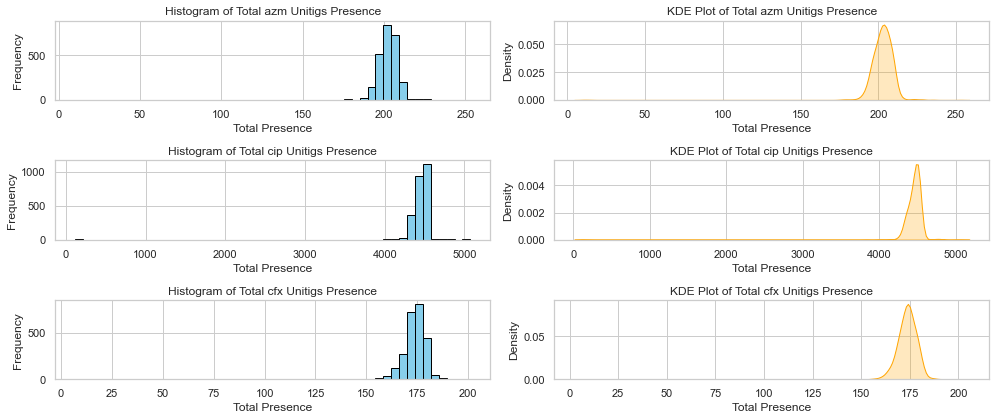

In [349]:
fig, axes = plt.subplots(3, 2, figsize=(14, 6))

axes[0,0].hist(azm_total_presence, bins=50, color='skyblue', edgecolor='black')
axes[0,0].set_title('Histogram of Total azm Unitigs Presence')
axes[0,0].set_xlabel('Total Presence')
axes[0,0].set_ylabel('Frequency')

sns.kdeplot(azm_total_presence, ax=axes[0,1], color='orange', fill=True)
axes[0,1].set_title('KDE Plot of Total azm Unitigs Presence')
axes[0,1].set_xlabel('Total Presence')
axes[0,1].set_ylabel('Density')

axes[1,0].hist(cip_total_presence, bins=50, color='skyblue', edgecolor='black')
axes[1,0].set_title('Histogram of Total cip Unitigs Presence')
axes[1,0].set_xlabel('Total Presence')
axes[1,0].set_ylabel('Frequency')

sns.kdeplot(cip_total_presence, ax=axes[1,1], color='orange', fill=True)
axes[1,1].set_title('KDE Plot of Total cip Unitigs Presence')
axes[1,1].set_xlabel('Total Presence')
axes[1,1].set_ylabel('Density')

axes[2,0].hist(cfx_total_presence, bins=50, color='skyblue', edgecolor='black')
axes[2,0].set_title('Histogram of Total cfx Unitigs Presence')
axes[2,0].set_xlabel('Total Presence')
axes[2,0].set_ylabel('Frequency')

sns.kdeplot(cfx_total_presence, ax=axes[2,1], color='orange', fill=True)
axes[2,1].set_title('KDE Plot of Total cfx Unitigs Presence')
axes[2,1].set_xlabel('Total Presence')
axes[2,1].set_ylabel('Density')
plt.tight_layout()



## Normalize Unitig Presence and Calculate Ratios of Unitig Presence
10. normalize the unitig presence data and calculate the ratio of presence of unitigs over all unitigs for each strain. Normalizing the unitig presence data and taking the ratio of presence for each sample both can prevent numerical instability and lead to potentially faster convergence.

In [350]:
azm_presence_ratio = azm_total_presence / azm_sr.shape[1]
cip_presence_ratio = cip_total_presence / cip_sr.shape[1]
cfx_presence_ratio = cfx_total_presence / cfx_sr.shape[1]

normal_azm_total_presence = pd.Series(normalizer.fit_transform(azm_total_presence.values.reshape(-1,1)).reshape((len(azm_total_presence))), name="azm_presence")
normal_cip_total_presence = pd.Series(normalizer.fit_transform(cip_total_presence.values.reshape(-1,1)).reshape((len(cip_total_presence))), name='cip_presence')
normal_cfx_total_presence = pd.Series(normalizer.fit_transform(cfx_total_presence.values.reshape(-1,1)).reshape((len(cfx_total_presence))), name="cfx_presence")

# This can help to see if you need to slice the ratios
min_length = min(normal_azm_total_presence.shape[0], 
                 normal_cip_total_presence.shape[0], 
                 normal_cfx_total_presence.shape[0], 
                 azm_presence_ratio.shape[0], 
                 cip_presence_ratio.shape[0], 
                 cfx_presence_ratio.shape[0])

# Slicing if necessary
normal_azm_total_presence = normal_azm_total_presence[:min_length]
normal_cip_total_presence = normal_cip_total_presence[:min_length]
normal_cfx_total_presence = normal_cfx_total_presence[:min_length]
azm_presence_ratio = azm_presence_ratio[:min_length]
cip_presence_ratio = cip_presence_ratio[:min_length]
cfx_presence_ratio = cfx_presence_ratio[:min_length]

# Create DataFrame again
normal_features = pd.DataFrame({"azm_presence":normal_azm_total_presence, 
                                "cip_presence":normal_cip_total_presence,
                                "cfx_presence":normal_cfx_total_presence})
ratio_features = pd.DataFrame({"azm_presence_ratio": azm_presence_ratio,
                               "cip_presence_ratio": cip_presence_ratio,
                                "cfx_presence_ratio": cfx_presence_ratio})

normal_features_reset = normal_features.reset_index(drop=True)
ratio_features_reset = ratio_features.reset_index(drop=True)

print(normal_features_reset.columns)
unitig_features = pd.concat([ratio_features_reset, normal_features_reset],axis=1).astype(float)


Index(['azm_presence', 'cip_presence', 'cfx_presence'], dtype='object')


## Unitig Presence Correllation Analysis

11. determine correlation of engineered unitig features to labels by calculating correlation coefficients. This analysis helps identify which unitig features have significant relationships to the labels allowing us to assess their predictive relevance.


Index(['azm_sr', 'cfx_sr', 'cip_sr', 'azm_presence_ratio',
       'cip_presence_ratio', 'cfx_presence_ratio', 'azm_presence',
       'cip_presence', 'cfx_presence'],
      dtype='object') (2490, 9)


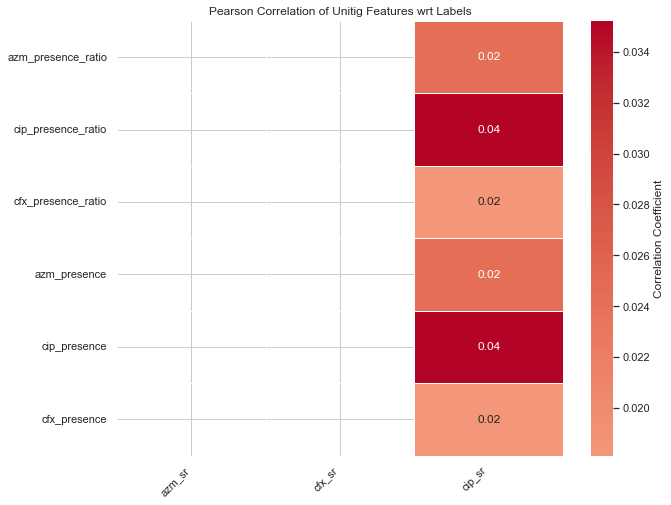

In [351]:
label_columns = ['azm_sr', 'cfx_sr', 'cip_sr'] #Separated labels from numerical columns

train_inputs_reset = train_inputs[label_columns].reset_index(drop=True)

stackedDF = pd.concat([train_inputs_reset, unitig_features],axis=1).astype(float)
print(stackedDF.columns, stackedDF.shape)

correlation_matrix = stackedDF.corr() #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html   !!! Pearson by default
feature_label_corr = correlation_matrix.loc[unitig_features.columns, label_columns] #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html

plt.figure(figsize=(10, 8)) #Need to use seaborn. idk how to make matplotlib heatmap
sns.heatmap(
    feature_label_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    fmt=".2f",
    cbar_kws={'label': 'Correlation Coefficient'} 
)
plt.title("Pearson Correlation of Unitig Features wrt Labels")
plt.xticks(rotation=45, ha='right') #Qol

plt.show()

## Pairwise Correlation Between Unitig Features

In [352]:
#print(stackedDF)
#sns.pairplot(stackedDF)

## Engineer Polynomial Features
12. Create polynomial features to expose potential nonlinear relationships between existing features and labels. Involves generating new features by raising the original features to a specified power. This can enhance the model's ability to learn more complex patterns and improve predictive performance

In [353]:
from sklearn.preprocessing import PolynomialFeatures

mX_azm = train_inputs[['azm_mic','log2_azm_mic']]
mX_cip = train_inputs[['cip_mic','log2_cip_mic']]
mX_cfx = train_inputs[['cfx_mic','log2_cfx_mic']]

mX_azm_reset = mX_azm.reset_index(drop=True)
mX_cip_reset = mX_cip.reset_index(drop=True)
mX_cfx_reset = mX_cfx.reset_index(drop=True)


uX_azm = unitig_features['azm_presence']
uX_cip = unitig_features['cip_presence']
uX_cfx = unitig_features['cfx_presence']

uX_azm_reset = uX_azm.reset_index(drop=True)
uX_cip_reset = uX_cip.reset_index(drop=True)
uX_cfx_reset = uX_cfx.reset_index(drop=True)


X_azm = pd.concat([mX_azm_reset, uX_azm_reset], axis=1)
X_cip = pd.concat([mX_cip_reset, uX_cip_reset], axis=1)
X_cfx = pd.concat([mX_cfx_reset, uX_cfx_reset], axis=1)

def create_polynomial_features(df, degree=3):
    poly_df = pd.DataFrame()
    for d in range(2, degree):
        for col in df.columns:
            poly_df[f"{col}^{d}"] = df[col] ** d
    return poly_df

X_azm_poly = create_polynomial_features(X_azm)
X_cip_poly = create_polynomial_features(X_cip)
X_cfx_poly = create_polynomial_features(X_cfx)

poly_features = pd.concat([X_azm_poly, X_cip_poly, X_cfx_poly], axis=1).astype(float)
poly_features.head()

azm_mic^2  log2_azm_mic^2  azm_presence^2     cip_mic^2  log2_cip_mic^2  \
0  1.640527e-07        0.083783        0.567139  9.765928e-10        0.009855   
1  1.640527e-07        0.083783        0.560958  1.350796e-02        0.242330   
2  5.266821e-08        0.063883        0.466663  4.334373e-03        0.878655   
3  1.640527e-07        0.068611        0.554810  4.785306e-08        0.059880   
4  9.765910e-10        0.010527        0.560958  9.765928e-10        0.009855   

   cip_presence^2  cfx_mic^2  log2_cfx_mic^2  cfx_presence^2  
0        0.704733   0.000004        0.095175        0.688729  
1        0.712201   0.000004        0.095175        0.697311  
2        0.561820   0.000018        0.121591        0.566373  
3        0.748038   0.000003        0.090796        0.697311  
4        0.704394   0.000004        0.095175        0.714635

## More Visualization
13. determine correlation of polynomial features to labels by calculating correlation coefficients. This analysis helps identify which polynomial features have significant relationships to the labels allowing us to assess their predictive relevance.

Index(['azm_sr', 'cfx_sr', 'cip_sr', 'azm_mic^2', 'log2_azm_mic^2',
       'azm_presence^2', 'cip_mic^2', 'log2_cip_mic^2', 'cip_presence^2',
       'cfx_mic^2', 'log2_cfx_mic^2', 'cfx_presence^2'],
      dtype='object') (2490, 12)


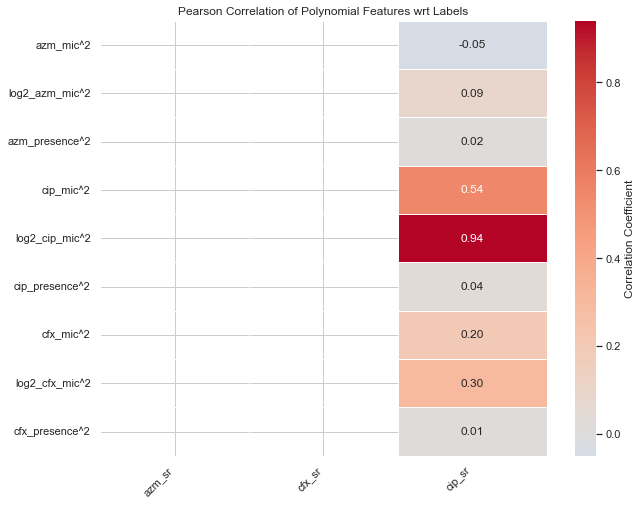

In [354]:
label_columns = ['azm_sr', 'cfx_sr', 'cip_sr'] #Separated labels from numerical columns

train_inputs_reset = train_inputs[label_columns].reset_index(drop=True)

stackedDF = pd.concat([train_inputs_reset, poly_features],axis=1).astype(float)
print(stackedDF.columns, stackedDF.shape)

correlation_matrix = stackedDF.corr() #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html   !!! Pearson by default
feature_label_corr = correlation_matrix.loc[poly_features.columns, label_columns] #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html

plt.figure(figsize=(10, 8)) #Need to use seaborn. idk how to make matplotlib heatmap
sns.heatmap(
    feature_label_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    fmt=".2f",
    cbar_kws={'label': 'Correlation Coefficient'} 
)
plt.title("Pearson Correlation of Polynomial Features wrt Labels")
plt.xticks(rotation=45, ha='right') #Qol

plt.show()

## Identify Impactful Features
14. Identify engineered features with a high correlation to the labels. Select features that pass a threshold of correlation. visualize the density and distribution of these features. This helps illustrate the distribution patterns withing the engineered variables and how they vary relative to the labels.

Impactful features for azm_sr
Impactful features for cfx_sr
Impactful features for cip_sr
 * log2_azm_mic^2: Correlation = 0.08663876016879395
 * cip_mic^2: Correlation = 0.5433785112439063
 * log2_cip_mic^2: Correlation = 0.9402184143619166
 * cfx_mic^2: Correlation = 0.20415393162939374
 * log2_cfx_mic^2: Correlation = 0.296711891432274


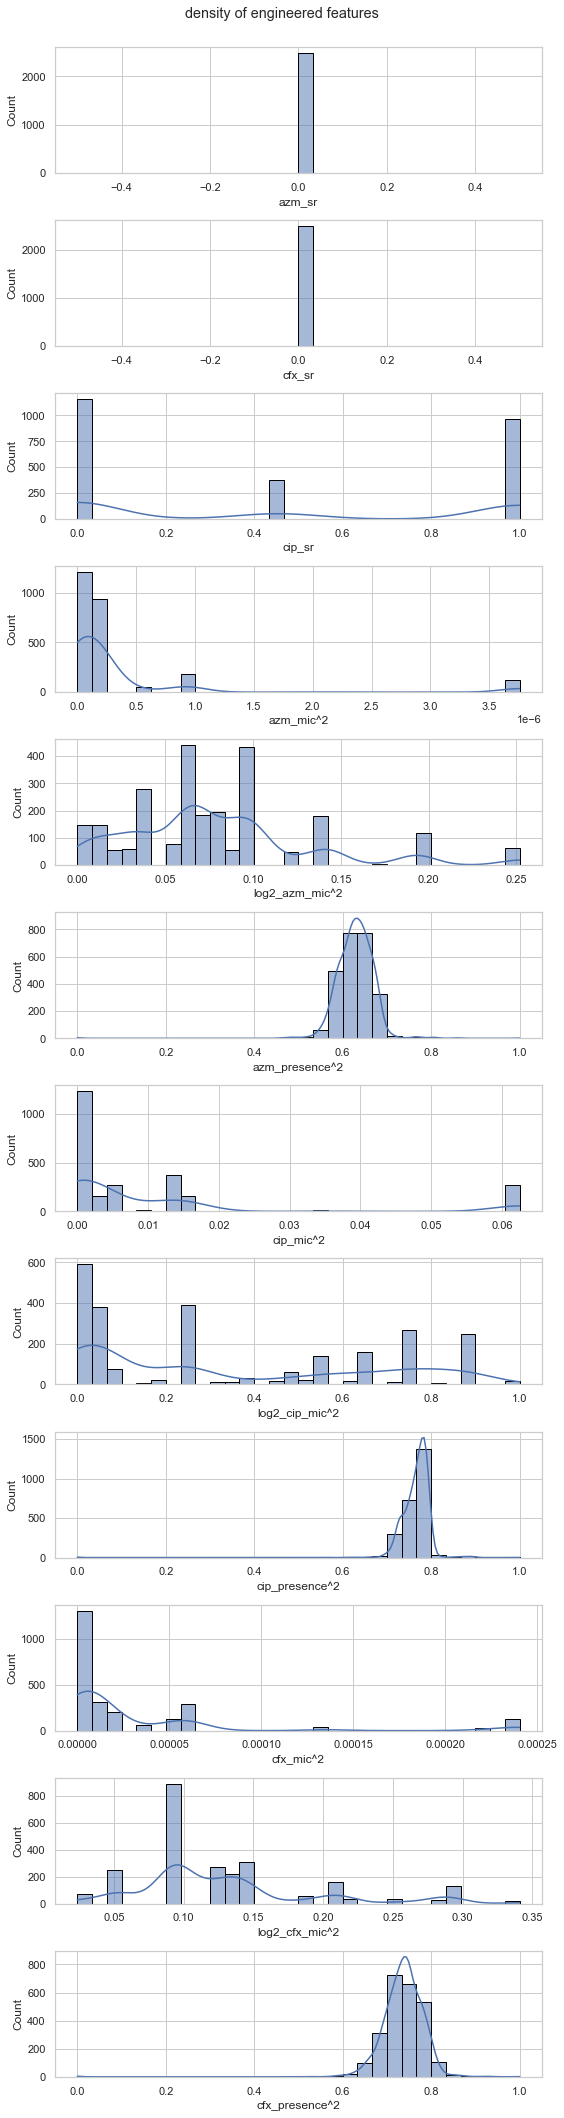

In [355]:
impact_threshold = 0.05
feature_impact = {}

for label in label_columns:
    correlations = feature_label_corr[label]

    significant_features = correlations[abs(correlations) > impact_threshold].index.tolist() #abs because negative impacts matter too
    feature_impact[label] = significant_features

fig, axes = plt.subplots(len(stackedDF.columns), figsize=(8,30))
fig.suptitle("density of engineered features")

targets = []

for label, features in feature_impact.items():
    print(f"Impactful features for {label}")
    for feature in features:
        corr_value = feature_label_corr.loc[feature, label]
        print(f" * {feature}: Correlation = {corr_value}")
        targets.append(feature)

i=0
for feature in stackedDF.columns:
    sns.histplot(stackedDF[feature],bins=30, kde=True, ax=axes[i], edgecolor="black")
    i+=1
    plt.tight_layout(rect=[0, 0, 1, 0.98])

## Pairwise Correlation Between Polynomial Features

In [420]:
#print(stackedDF.columns)
#sns.pairplot(stackedDF)

In [421]:
azm_sr.head()
azm_sr_unitigs = azm_sr.columns[:]

In [454]:
def separate_unitig_columns(table):
    # Create an empty list to hold new columns
    new_columns = []
    
    # Create a new DataFrame directly from the existing one using list comprehension
    for col in table.columns:
        labels = col.split(",")
        # Append tuples of labels and their corresponding data to new_columns
        new_columns.extend([(label, table[col]) for label in labels])

    # Create the new DataFrame by concatenating the new columns
    df = pd.DataFrame({label: data for label, data in new_columns})

    # Calculate max length of unitig columns
    unitig_lengths = [len(label) for label in df.columns]
    max_length = max(unitig_lengths) if unitig_lengths else 0
    
    return df, max_length

# Call the optimized function for each DataFrame
azm_sr_unitigs, azm_unitigs_max_length = separate_unitig_columns(azm_sr)
cip_sr_unitigs, cip_unitigs_max_length = separate_unitig_columns(cip_sr)
cfx_sr_unitigs, cfx_unitigs_max_length = separate_unitig_columns(cfx_sr)

In [423]:
metadata.head()

Country Continent Beta.lactamase  Azithromycin  Ciprofloxacin  \
Sample_ID                                                                  
ERR1549286      UK    Europe            NaN         256.0       12.56588   
ERR1549290      UK    Europe            NaN         256.0       12.56588   
ERR1549291      UK    Europe            NaN         256.0       12.56588   
ERR1549288      UK    Europe            NaN         256.0       12.56588   
ERR1549299      UK    Europe            NaN         256.0       12.56588   

            Ceftriaxone   Cefixime  Tetracycline  Penicillin      NG_MAST  \
Sample_ID                                                                   
ERR1549286         16.0  24.103413     15.521028   19.365416  9768.000000   
ERR1549290          4.0  24.103413     15.521028   19.365416  9768.000000   
ERR1549291          6.0  24.103413     15.521028   19.365416  9768.000000   
ERR1549288          8.0  24.103413     15.521028   19.365416  9768.000000   
ERR1549299         12.0  24.103413     15.521028   19.365416  4125.170898   

            ...   pen_mic  log2_azm_mic  log2_cip_mic  log2_cro_mic  \
Sample_ID   ...                                                       
ERR1549286  ...  3.325683           9.0     -2.089714     -5.965784   
ERR1549290  ...  3.325683           9.0     -2.089714     -7.965784   
ERR1549291  ...  3.325683           9.0     -2.089714     -7.380822   
ERR1549288  ...  3.325683           9.0     -2.089714     -6.965784   
ERR1549299  ...  3.325683           9.0     -2.089714     -6.380822   

            log2_cfx_mic  log2_tet_mic  log2_pen_mic  azm_sr    cip_sr  \
Sample_ID                                                                
ERR1549286     -5.213222      0.948753     -0.401686     1.0  0.455826   
ERR1549290     -5.213222      0.948753     -0.401686     1.0  0.455826   
ERR1549291     -5.213222      0.948753     -0.401686     1.0  0.455826   
ERR1549288     -5.213222      0.948753     -0.401686     1.0  0.455826   
ERR1549299     -5.213222      0.948753     -0.401686     1.0  0.455826   

             cfx_sr  
Sample_ID            
ERR1549286  0.00176  
ERR1549290  0.00176  
ERR1549291  0.00176  
ERR1549288  0.00176  
ERR1549299  0.00176  

[5 rows x 26 columns]

In [493]:
print(azm_sr_unitigs.index[:])
impute_cols_by_skew(metadata, numeric_columns)
aligned_metadata = metadata.reindex(azm_sr_unitigs.index)
aligned_metadata.head()

Index(['ERR1549290', 'ERR1549291', 'ERR1549288', 'ERR1549299', 'ERR1549292',
       'ERR1549298', 'ERR1549300', 'ERR1549295', 'ERR1549294', 'ERR1549293',
       ...
       'ERR2172299', 'ERR2172310', 'ERR2172311', 'ERR2172316', 'ERR2172320',
       'ERR2172323', 'ERR2172339', 'ERR2172342', 'ERR2172344', 'ERR2172346'],
      dtype='object', length=2490)


Country Continent Beta.lactamase  Azithromycin  Ciprofloxacin  \
ERR1549290      UK    Europe            NaN         256.0       12.56588   
ERR1549291      UK    Europe            NaN         256.0       12.56588   
ERR1549288      UK    Europe            NaN         256.0       12.56588   
ERR1549299      UK    Europe            NaN         256.0       12.56588   
ERR1549292      UK    Europe            NaN         256.0       12.56588   

            Ceftriaxone   Cefixime  Tetracycline  Penicillin      NG_MAST  \
ERR1549290          4.0  24.103413     15.521028   19.365416  9768.000000   
ERR1549291          6.0  24.103413     15.521028   19.365416  9768.000000   
ERR1549288          8.0  24.103413     15.521028   19.365416  9768.000000   
ERR1549299         12.0  24.103413     15.521028   19.365416  4125.170898   
ERR1549292         23.0  24.103413     15.521028   19.365416  9768.000000   

            ...   pen_mic  log2_azm_mic  log2_cip_mic  log2_cro_mic  \
ERR1549290  ...  3.325683           9.0     -2.089714     -7.965784   
ERR1549291  ...  3.325683           9.0     -2.089714     -7.380822   
ERR1549288  ...  3.325683           9.0     -2.089714     -6.965784   
ERR1549299  ...  3.325683           9.0     -2.089714     -6.380822   
ERR1549292  ...  3.325683           9.0     -2.089714     -5.442222   

            log2_cfx_mic  log2_tet_mic  log2_pen_mic  azm_sr    cip_sr  \
ERR1549290     -5.213222      0.948753     -0.401686     1.0  0.455826   
ERR1549291     -5.213222      0.948753     -0.401686     1.0  0.455826   
ERR1549288     -5.213222      0.948753     -0.401686     1.0  0.455826   
ERR1549299     -5.213222      0.948753     -0.401686     1.0  0.455826   
ERR1549292     -5.213222      0.948753     -0.401686     1.0  0.455826   

             cfx_sr  
ERR1549290  0.00176  
ERR1549291  0.00176  
ERR1549288  0.00176  
ERR1549299  0.00176  
ERR1549292  0.00176  

[5 rows x 26 columns]

In [551]:
from tqdm import tqdm
sr_class = ["azm", "cip", "cfx"]
inputs_labels = {}
for col in tqdm(azm_sr_unitigs.columns):
    valid_rows = azm_sr_unitigs[col].astype(bool) & azm_sr_unitigs.index.isin(metadata.index)
    sr = aligned_metadata.loc[valid_rows, 'azm_sr'].sum()
    inputs_labels[col] = {'sr_class' : sr_class.index('azm'), 'sr' : sr};

for col in tqdm(cip_sr_unitigs.columns):
    valid_rows = cip_sr_unitigs[col].astype(bool) & cip_sr_unitigs.index.isin(metadata.index)
    sr = aligned_metadata.loc[valid_rows, 'cip_sr'].sum()
    inputs_labels[col] = {'sr_class' : sr_class.index('cip'), 'sr' : sr};

for col in tqdm(cfx_sr_unitigs.columns):
    valid_rows = cfx_sr_unitigs[col].astype(bool) & cfx_sr_unitigs.index.isin(metadata.index)
    sr = aligned_metadata.loc[valid_rows, 'cfx_sr'].sum()
    inputs_labels[col] = {'sr_class' : sr_class.index('cfx'), 'sr' : sr};

inputs_labels = pd.DataFrame.from_dict(inputs_labels, orient='index')


100%|██████████| 409/409 [00:00<00:00, 1536.11it/s]


In [552]:
inputs_labels = inputs_labels.T
print(inputs_labels.index)
inputs_labels.loc['sr'] = normalizer.fit_transform(inputs_labels.loc['sr'].values.reshape(-1,1)).flatten()


Index(['sr_class', 'sr'], dtype='object')


In [553]:
inputs_labels


CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG  \
sr_class                                              0.0   
sr                                                    0.0   

          TACCGTAACCGGCAATGCGGATATTACGGTC  CAGACGGCATTTTTTTTGCGTTTTTCGGGAGG  \
sr_class                              0.0                          0.000000   
sr                                    0.0                          0.000885   

          AACGGGTTTTCAGACGGCATTCGATATCGGGACG  \
sr_class                                 0.0   
sr                                       0.0   

          CCAAAAATTACCCGCGTTGACGTAGCTAAAGA  \
sr_class                               0.0   
sr                                     0.0   

          CGGACCGGTATTCCGTCGAAATCACCGCCGTCAACCGCCCC  \
sr_class                                        0.0   
sr                                              0.0   

          TGAAATTGTCCATCTCGTATGCCGTCTTCTGCTTG  \
sr_class                                  0.0   
sr                                        0.0   

          TACGGTATTGTCCGCATTATTAAACTCAAAACC  \
sr_class                                0.0   
sr                                      0.0   

          AGAAGACGGCATACGAGATGGACAATTTCATCC  \
sr_class                                0.0   
sr                                      0.0   

          GGCATTTTTTTTGCGTTTTTCGGGAGGGGGCGGC  ...  \
sr_class                                 0.0  ...   
sr                                       0.0  ...   

          GTCGATGTTTTGAGGAACAAACTCGAACAGAAA  \
sr_class                           2.000000   
sr                                 0.003887   

          ACCGCCATCAGTTTTCCGCTCATCGGAGGAAGGG  \
sr_class                            2.000000   
sr                                  0.003887   

          TCCCAACAGACCCGGCCGGGCAGACAGCGAACAG  \
sr_class                            2.000000   
sr                                  0.003887   

          GACGGTTTCTTTATTTGATTTGAACGGAAAAACCAT  \
sr_class                              2.000000   
sr                                    0.003887   

          CGTCAAAGACGCCAACGACGCCGGCACCAAAATCGACAC  \
sr_class                                 2.000000   
sr                                       0.003887   

          CCATCAAAACCGCCATCAGTTTTCCGCTCATCGGA  \
sr_class                             2.000000   
sr                                   0.003887   

          CCAAGCCACGTCGGCATTCGGTTTCGAGCCGATGTCCA  \
sr_class                                2.000000   
sr                                      0.003887   

          TTCAGGCTGCCGCCCATAATTTTTTTGAAGGGC  \
sr_class                           2.000000   
sr                                 0.003887   

          GGAACGCCTGTCCGAGCTTGTCGATGTGCCGGT  \
sr_class                           2.000000   
sr                                 0.003887   

          CAGCGCATCGGTCATTGTCGGACTCGAGCCGCTGCTGATG  
sr_class                                  2.000000  
sr                                        0.003887  

[2 rows x 11835 columns]

In [554]:
from enum import Enum
import itertools
nucleotides = ['A', 'C', 'G', 'T']

unitigs_3mers = [''.join(combination) for combination in itertools.product(nucleotides, repeat=3)]

In [555]:
def convert_unitig_to_vector(unitig):
    vector = [0] * 256
    
    for i in range(len(unitig) - 2):
        kmer = unitig[i:i + 3]
        if kmer in unitigs_3mers:
            index = unitigs_3mers.index(kmer)
            print(kmer, index)
            if index < 256:
                vector[index] += 1
    return vector

In [556]:
unitigs = inputs_labels.columns

# Convert all unitigs to vectors
unitig_vectors = [convert_unitig_to_vector(unitig) for unitig in unitigs]
inputs_labels.loc['unitig_vectors'] = unitig_vectors


CTT 31
TTA 60
TAA 48
AAC 1
ACA 4
CAT 19
ATA 12
TAT 51
ATT 15
TTT 63
TTG 62
TGC 57
GCC 37
CCT 23
CTT 31
TTT 63
TTG 62
TGA 56
GAT 35
ATT 15
TTT 63
TTT 63
TTT 63
TTG 62
TGA 56
GAA 32
AAG 2
AGA 8
GAA 32
AAG 2
AGC 9
GCT 39
CTG 30
TGC 57
GCC 37
CCA 20
CAC 17
ACG 6
CGC 25
GCC 37
CCG 22
CGG 26
GGC 41
GCA 36
CAG 18
TAC 49
ACC 5
CCG 22
CGT 27
GTA 44
TAA 48
AAC 1
ACC 5
CCG 22
CGG 26
GGC 41
GCA 36
CAA 16
AAT 3
ATG 14
TGC 57
GCG 38
CGG 26
GGA 40
GAT 35
ATA 12
TAT 51
ATT 15
TTA 60
TAC 49
ACG 6
CGG 26
GGT 43
GTC 45
CAG 18
AGA 8
GAC 33
ACG 6
CGG 26
GGC 41
GCA 36
CAT 19
ATT 15
TTT 63
TTT 63
TTT 63
TTT 63
TTT 63
TTT 63
TTG 62
TGC 57
GCG 38
CGT 27
GTT 47
TTT 63
TTT 63
TTT 63
TTC 61
TCG 54
CGG 26
GGG 42
GGA 40
GAG 34
AGG 10
AAC 1
ACG 6
CGG 26
GGG 42
GGT 43
GTT 47
TTT 63
TTT 63
TTC 61
TCA 52
CAG 18
AGA 8
GAC 33
ACG 6
CGG 26
GGC 41
GCA 36
CAT 19
ATT 15
TTC 61
TCG 54
CGA 24
GAT 35
ATA 12
TAT 51
ATC 13
TCG 54
CGG 26
GGG 42
GGA 40
GAC 33
ACG 6
CCA 20
CAA 16
AAA 0
AAA 0
AAA 0
AAT 3
ATT 15
TTA 60
TAC 49
ACC 5
CC

In [557]:
inputs_labels.head()

CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [0, 1, 2, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, ...   

                                  TACCGTAACCGGCAATGCGGATATTACGGTC  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [0, 1, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...   

                                 CAGACGGCATTTTTTTTGCGTTTTTCGGGAGG  \
sr_class                                                      0.0   
sr                                                       0.000885   
unitig_vectors  [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ...   

                               AACGGGTTTTCAGACGGCATTCGATATCGGGACG  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [0, 1, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 1, 1, 0, ...   

                                 CCAAAAATTACCCGCGTTGACGTAGCTAAAGA  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [4, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...   

                        CGGACCGGTATTCCGTCGAAATCACCGCCGTCAACCGCCCC  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [1, 1, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   

                              TGAAATTGTCCATCTCGTATGCCGTCTTCTGCTTG  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...   

                                TACGGTATTGTCCGCATTATTAAACTCAAAACC  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [3, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...   

                                AGAAGACGGCATACGAGATGGACAATTTCATCC  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [0, 0, 1, 1, 1, 0, 2, 0, 3, 0, 0, 0, 1, 1, 1, ...   

                               GGCATTTTTTTTGCGTTTTTCGGGAGGGGGCGGC  ...  \
sr_class                                                      0.0  ...   
sr                                                            0.0  ...   
unitig_vectors  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...  ...   

                                GTCGATGTTTTGAGGAACAAACTCGAACAGAAA  \
sr_class                                                      2.0   
sr                                                       0.003887   
unitig_vectors  [2, 3, 0, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...   

                               ACCGCCATCAGTTTTCCGCTCATCGGAGGAAGGG  \
sr_class                                                      2.0   
sr                                                       0.003887   
unitig_vectors  [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, ...   

                               TCCCAACAGACCCGGCCGGGCAGACAGCGAACAG  \
sr_class                                                      2.0   
sr                                                       0.003887   
unitig_vectors  [0, 2, 0, 0, 3, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, ...   

                             GACGGTTTCTTTATTTGATTTGAACGGAAAAACCAT  \
sr_class                                                      2.0   
sr                                                       0.003887   
unitig_vectors  [3, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                          CGTCAAAGACGCCAACGACGCCGGCACCAAAATCGACAC  \
sr_class                                           

K clustering

In [558]:
from sklearn.cluster import KMeans
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=42)

kmeans.fit(unitig_vectors)
labels = kmeans.labels_
inputs_labels.loc['cluster'] = labels


c:\Users\deros\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [559]:
inputs_labels.head()


CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [0, 1, 2, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, ...   
cluster                                                         0   

                                  TACCGTAACCGGCAATGCGGATATTACGGTC  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [0, 1, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...   
cluster                                                         0   

                                 CAGACGGCATTTTTTTTGCGTTTTTCGGGAGG  \
sr_class                                                      0.0   
sr                                                       0.000885   
unitig_vectors  [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, ...   
cluster                                                         0   

                               AACGGGTTTTCAGACGGCATTCGATATCGGGACG  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [0, 1, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 1, 1, 0, ...   
cluster                                                         0   

                                 CCAAAAATTACCCGCGTTGACGTAGCTAAAGA  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [4, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...   
cluster                                                         2   

                        CGGACCGGTATTCCGTCGAAATCACCGCCGTCAACCGCCCC  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [1, 1, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
cluster                                                         1   

                              TGAAATTGTCCATCTCGTATGCCGTCTTCTGCTTG  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...   
cluster                                                         0   

                                TACGGTATTGTCCGCATTATTAAACTCAAAACC  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [3, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...   
cluster                                                         2   

                                AGAAGACGGCATACGAGATGGACAATTTCATCC  \
sr_class                                                      0.0   
sr                                                            0.0   
unitig_vectors  [0, 0, 1, 1, 1, 0, 2, 0, 3, 0, 0, 0, 1, 1, 1, ...   
cluster                                                         0   

                               GGCATTTTTTTTGCGTTTTTCGGGAGGGGGCGGC  ...  \
sr_class                                                      0.0  ...   
sr                                                            0.0  ...   
unitig_vectors  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...  ...   
cluster                                                         0  ...   

                                GTCGATGTTTTGAGGAACAAACTCGAACAGAAA  \
sr_class                                                      2.0   
sr                                                       0.003887   
unitig_vectors  [2, 3, 0, 0, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...   
cluster                                                         2   

                               ACCGCCATCAGTTTTCCGCTCATCGGAGGAAGGG  \
sr_class                                                      2.0   
sr                                               

c:\Users\deros\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


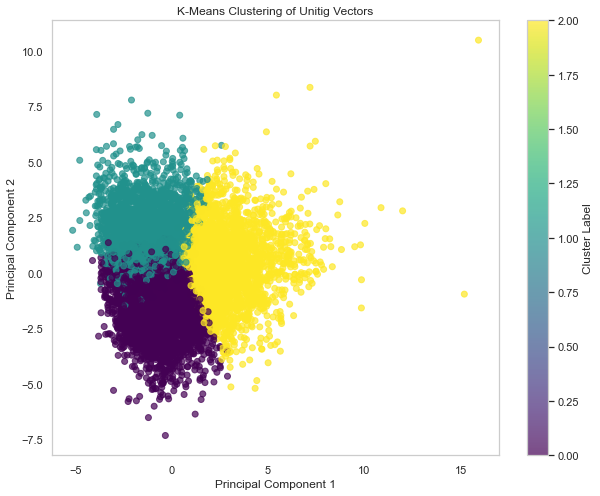

In [560]:
# visualize with pricipal component analysis

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assuming unitig_vectors is a list of vectors you generated from your unitigs
unitig_vectors = np.array(unitig_vectors)  # Convert list to a NumPy array

# Create a DataFrame if needed
df_unitig_vectors = pd.DataFrame(unitig_vectors)

num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=42)

kmeans.fit(df_unitig_vectors)

labels = kmeans.labels_

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
unitig_vectors_pca = pca.fit_transform(df_unitig_vectors)

# Create a DataFrame for PCA results
df_pca = pd.DataFrame(unitig_vectors_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = labels

# Plotting the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['cluster'], cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering of Unitig Vectors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid()
plt.show()

In [561]:
# Assuming unitig_vectors is a NumPy array and you have labels
# Create your labels based on your original data, e.g., from `inputs_labels`
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

labels = list(inputs_labels.loc['sr'])  # Replace with your actual labels corresponding to each unitig vector
# Convert to DataFrame if not already
df_unitig_vectors = pd.DataFrame(unitig_vectors)
print(df_unitig_vectors)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_unitig_vectors, labels, test_size=0.2, random_state=42)

# Initialize the SVM model
svm_model = SVR()  # You can also try 'rbf', 'poly', etc.

# Train the model
svm_model.fit(X_train, y_train)

       0    1    2    3    4    5    6    7    8    9    ...  246  247  248  \
0        0    1    2    0    1    0    1    0    1    1  ...    0    0    0   
1        0    1    0    1    0    2    1    0    0    0  ...    0    0    0   
2        0    0    0    0    0    0    1    0    1    0  ...    0    0    0   
3        0    1    0    0    0    0    3    0    1    0  ...    0    0    0   
4        4    0    1    1    0    1    1    0    1    1  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
11830    2    1    0    0    0    1    0    0    0    0  ...    0    0    0   
11831    0    0    1    0    0    0    1    0    0    2  ...    0    0    0   
11832    0    0    1    1    0    0    0    0    0    0  ...    0    0    0   
11833    0    1    0    0    0    0    1    0    0    1  ...    0    0    0   
11834    0    0    0    0    0    0    0    1    0    2  ...    0    0    0   

       249  250  251  252  253  254  255  
0       

SVR()

[0.28875977 0.05383712 0.3205218  ... 0.07671007 0.46310288 0.21263184]
Mean Squared Error: 0.23899011823450514
Mean Absolute Error: 0.4206209502818751
R-squared: -0.14289708191027706


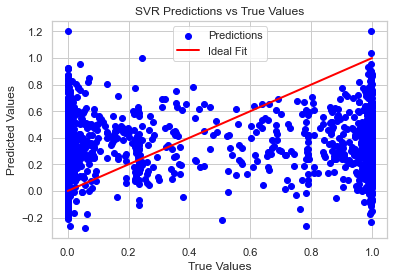

In [562]:
# Make predictions
from sklearn.metrics import mean_absolute_error, r2_score
y_pred = svm_model.predict(X_test)
print(y_pred)
MSE = np.square(np.subtract(y_test,y_pred)).mean()
print(f"Mean Squared Error: {MSE}")
MAE = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {MAE}")
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

plt.scatter(y_test, y_pred, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('SVR Predictions vs True Values')
plt.legend()
plt.show()


The svm is not fitting the data well

XGBoost Regression

In [563]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming X_train_scaled and y_train are already prepared
X_train, X_test, y_train, y_test = train_test_split(df_unitig_vectors, labels, test_size=0.4, random_state=42)

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

Mean Squared Error: 0.20735236362485113
Mean Absolute Error: 0.42976184139811163
R-squared: 0.008400794707729697


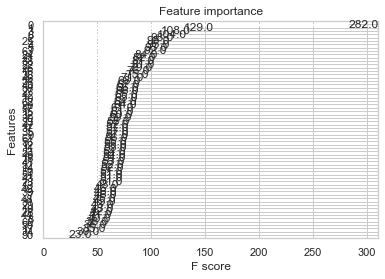

In [564]:
# Evaluate model performance
MSE = np.square(np.subtract(y_test,y_pred)).mean()
print(f"Mean Squared Error: {MSE}")
MAE = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {MAE}")
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

xgb.plot_importance(xgb_model)
plt.show()

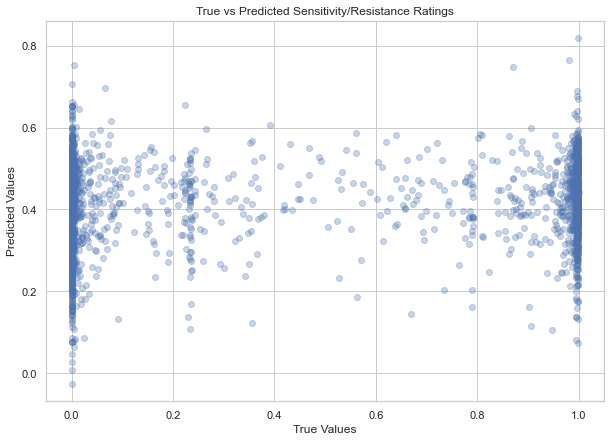

In [565]:
# Assuming y_test is the true labels and y_pred are the predictions
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Sensitivity/Resistance Ratings')
plt.show()

this regression doenst like it either

try convolutional neural netowrk

In [573]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
labels = np.array(labels)  # Replace this with your actual labels
from tensorflow.keras import regularizers

# Reshape unitig vectors for CNN input (samples, height, width, channels)
X = unitig_vectors.reshape((-1, unitig_vectors.shape[1], 1, 1))  # Shape: (num_samples, max_length, 1, 1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

print(X.shape)  # Check the shape
print(labels.shape)  # Check the shape of labels# Define the CNN model
model = keras.Sequential([
    layers.Conv2D(64, (3, 1), activation='relu', input_shape=(X.shape[1], 1, 1)),
    layers.MaxPooling2D(pool_size=(2, 1)),
    layers.Conv2D(64, (3, 1), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Use the Adam optimizer with an initial learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mean_absolute_error'])
# Print model summary
model.summary()

(11835, 256, 1, 1)
(11835,)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 254, 1, 64)        256       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 127, 1, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 1, 64)        12352     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 62, 1, 64)        0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 3968)              0         
                                                                 
 dense_24 (Dense)        

Epoch 1/1000
296/296 [==============================] - 2s 4ms/step - loss: 0.1863 - mean_absolute_error: 0.3675 - val_loss: 0.4256 - val_mean_absolute_error: 0.6324
Epoch 2/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1788 - mean_absolute_error: 0.3672 - val_loss: 0.3968 - val_mean_absolute_error: 0.6139
Epoch 3/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1754 - mean_absolute_error: 0.3656 - val_loss: 0.4525 - val_mean_absolute_error: 0.6483
Epoch 4/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1738 - mean_absolute_error: 0.3627 - val_loss: 0.3862 - val_mean_absolute_error: 0.6065
Epoch 5/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1724 - mean_absolute_error: 0.3609 - val_loss: 0.4334 - val_mean_absolute_error: 0.6363
Epoch 6/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1733 - mean_absolute_error: 0.3616 - val_loss: 0.4743 - val_mean_absolute_error: 0.6603
Epoc

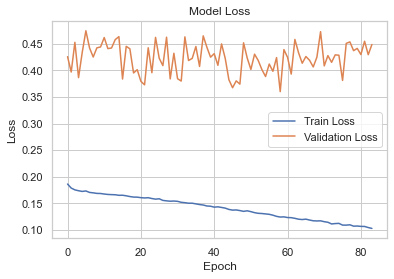

In [574]:
# Fit the model
history = model.fit(X, labels, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Plot training history (optional)
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [575]:
# Evaluate the model
loss, mae = model.evaluate(X, labels)
print(f"Loss: {loss}, Mean Absolute Error: {mae}")

370/370 [==============================] - 1s 2ms/step - loss: 0.1639 - mean_absolute_error: 0.3551
Loss: 0.16394685208797455, Mean Absolute Error: 0.35513007640838623
